# Identification, aggregation and analysis of complexes in the Protein Data Bank

## Disclaimer

This Jupyter notebook is supplementary material for the publication:

**"Identification, aggregation and analysis of complexes in the Protein Data Bank"**, Sri A et al., BioRxiv

The code in this notebook reproduces the analysis presented in the publication.

## Background

Macromolecular complexes are crucial functional units in virtually all cellular processes. Their atomic-level understanding is vital to understanding molecular mechanisms and affects applications, such as developing new therapeutics. The Protein Data Bank (PDB) is the central repository for experimentally determined macromolecular structures. However, it can be challenging to find all instances that represent the same assembly in the PDB due to the current PDB annotation practices, which do not include the annotation of assemblies. This study highlights the importance of annotations for macromolecular complexes and the need for more robust methods to identify and classify these complexes across the PDB. We propose a new approach that uses external resources such as the Complex Portal and Gene Ontology to describe assemblies accurately and put them into their biological contexts. We anticipate that the new approach to identifying and classifying complexes will improve the usability and utility of the PDB for researchers in the field of structural biology and drug discovery.

### Primary use case of this Jupyter notebook

This notebook demonstrates how to extract assembly information from the data generated by the weekly-updated complex identifier process of PDBe.
Using this notebook, or by slightly editing the code presented here, it is easy to identify assemblies such as:

* Protein-only assemblies
* Assemblies containing RNA or DNA
* Assemblies with components unmapped to UniProt (e.g. antibodies)

## Importing dependencies

This code imports several modules that are used in the script.

* The `pandas` module is used for data manipulation and analysis
* `utility` is a custom module that contains utility functions used in the script
* `matplotlib` is a plotting library and `pyplot` is a sublibrary within it, often used for creating static, two-dimensional plots.
* `constants` is a custom module that contains constants used in the script. `UNIPROT_PATTERN` and `RFAM_PATTERN` are constants that are defined in the constants module and used in the script.

In [1]:
import pandas as pd
import scripts.utility as ui
from matplotlib import pyplot as plt
from scripts.constants import UNIPROT_PATTERN, RFAM_PATTERN, RIBOSOMES_RFAM_MAPPING

## 1) Assemblies analysis

This section contains some general analyses that were carried out on assemblies across the whole PDB archieve in order to learn their numbers, composition of the assemblies and how many components in the assemblies are mapped to external resources such as [UniProt](https://www.uniprot.org/) for protein entities and [Rfam](https://rfam.org/) for RNA entities

### 1.1) Reading in the data

In [2]:
# Read the CSV file containing the data on assemblies
df = pd.read_csv("data/assemblies_data.csv")
# Create a dataframe where preferred assemblies is not null
df = df[~df["PREFERED_ASSEMBLIES"].isnull()]
df

,HASH_ASSEMBLY_STRING,ASSEMBLY_STRING,PDB_COMPLEX_ID,COMPLEX_PORTAL_ID,ASSEMBLY_NAME,NAME_SOURCE,ASSEMBLIES,PREFERED_ASSEMBLIES
0,8314d71be12be24dca4d3578fa195f89,A0A003_2,PDB-CPX-100001,NaN,NAD-dependent epimerase/dehydratase domain-con...,protein name from UniProt,"6kv9_1,6kvc_1","6kv9_1,6kvc_1"
1,643a8559f6cbf70685b67b7f8632cbca,"A0A009I821_1,A0A009L7S8_1,A0A014CLK2_1,A0A1V3D...",PDB-CPX-100002,NaN,70S ribosome and tRNA,ribosome,7m4w_1,7m4w_1
2,81eec1fce148c30c3e5e72bf1bd3a2fe,"A0A009I821_1,A0A009L7S8_1,A0A022IPE7_1,A0A0Q7F...",PDB-CPX-100003,NaN,70S ribosome and tRNA and RNA,ribosome,7ryf_1,7ryf_1
3,409d5dda207a9fcfdc5c74e5a2a197ee,"A0A009I821_1,A0A009L7S8_1,A0A022IPE7_1,A0A0Q7F...",PDB-CPX-100004,NaN,70S ribosome and tRNA and RNA,ribosome,7ryg_1,7ryg_1
4,da190bf125947d3ed688129f11fb80ad,"A0A009I821_1,A0A009L7S8_1,A0A022IPE7_1,A0A0Q7F...",PDB-CPX-100005,NaN,70S ribosome and tRNA,ribosome,7ryh_1,7ryh_1
...,...,...,...,...,...,...,...,...
100626,80f27bdf7ddaa60835f8f0968208d528,"antibody_8ek6_1_1,antibody_8ek6_2_1",PDB-CPX-200627,NaN,NaN,NaN,8ek6_1,8ek6_1
100627,5224dc0a715c4b43daf893919a926cc8,"antibody_8ekh_1_1,antibody_8ekh_2_1",PDB-CPX-200628,NaN,NaN,NaN,8ekh_1,8ekh_1
100628,a1b7fcd233f14686de97ae4b60deba88,"antibody_8fab_1_1,antibody_8fab_2_1",PDB-CPX-200629,NaN,NaN,NaN,"8fab_1,8fab_2",8fab_1
100629,56edf800a149d790de81f9e0420b83b5,"antibody_8gv4_1_1,antibody_8gv4_2_1",PDB-CPX-200630,NaN,NaN,NaN,"8gv4_1,8gv4_2",8gv4_1


### 1.2) Basic statistics

#### 1.2.1) Unique assemblies

First, we check how many unique assembly compositions are there in the PDB.

In [3]:
print("There are %i unique assembly compositions in the Protein Data Bank." % len(df))

There are 92239 unique assembly compositions in the Protein Data Bank.


In [106]:
# Column to indicate the exp methods used to solved the structures of each unique assembly composition
df["EXP_METHOD"] = df["ASSEMBLIES"].apply(lambda x: ui.get_exp_methods(x))
df["EXP_METHOD"].value_counts()

X-ray diffraction                 47481
Other                             32027
NMR                                6510
Other,X-ray diffraction            3549
NMR,X-ray diffraction               970
EM                                  865
NMR,Other,X-ray diffraction         384
NMR,Other                           271
EM,X-ray diffraction                 64
EM,Other                             62
EM,Other,X-ray diffraction           36
EM,NMR,X-ray diffraction              6
EM,NMR,Other,X-ray diffraction        5
EM,NMR                                5
EM,NMR,Other                          4
Name: EXP_METHOD, dtype: int64

In [124]:
# Column to indicate the species name for each unique assembly composition
df["SPECIES_NAME"] = df["ASSEMBLY_STRING"].apply(lambda x: ui.get_species_name(x))
df["SPECIES_NAME"].value_counts().head(10)

Humo sapiens                  16046
Escherichia coli               3469
transgenic mice                2828
Saccharomyces cerevisiae       2598
Thermus thermophilus           1043
Pseudomonas aeruginosa         1016
Mycobacterium tuberculosis      957
Arabis thaliana                 945
Mus norvegicus                  935
Bacillus subtilis               816
Name: SPECIES_NAME, dtype: int64

#### 1.2.2) Unique assemblies containing proteins

Next, we look at how many of these unique assemblies contain proteins.

In [6]:
# Column to indicate the number of assemblies each unique assembly has
df["NUM_ASSEMBLIES"] = df["ASSEMBLIES"].apply(lambda x: ui.count_assemblies(x))

# Column to indicate the number of distinct PDBIDs each unique assembly has
df["NUM_PDB"] = df["ASSEMBLIES"].apply(lambda x: ui.count_unique_pdb(x))

# Column to indicate whether each unique assembly has a protein component
df["hasProteinComponent"] = df["ASSEMBLY_STRING"].apply(lambda x: ui.check_for_protein(x))

df[df["hasProteinComponent"] == True].head()

,HASH_ASSEMBLY_STRING,ASSEMBLY_STRING,PDB_COMPLEX_ID,COMPLEX_PORTAL_ID,ASSEMBLY_NAME,NAME_SOURCE,ASSEMBLIES,PREFERED_ASSEMBLIES,EXP_METHOD,SPECIES_NAME,NUM_ASSEMBLIES,NUM_PDB,hasProteinComponent
0,8314d71be12be24dca4d3578fa195f89,A0A003_2,PDB-CPX-100001,NaN,NAD-dependent epimerase/dehydratase domain-con...,protein name from UniProt,"6kv9_1,6kvc_1","6kv9_1,6kvc_1",Other,culture-collection:NRRL:B:12104 [[Streptomyces,2,2,True
1,643a8559f6cbf70685b67b7f8632cbca,"A0A009I821_1,A0A009L7S8_1,A0A014CLK2_1,A0A1V3D...",PDB-CPX-100002,NaN,70S ribosome and tRNA,ribosome,7m4w_1,7m4w_1,Other,Acinetobacter baumannii,1,1,True
2,81eec1fce148c30c3e5e72bf1bd3a2fe,"A0A009I821_1,A0A009L7S8_1,A0A022IPE7_1,A0A0Q7F...",PDB-CPX-100003,NaN,70S ribosome and tRNA and RNA,ribosome,7ryf_1,7ryf_1,Other,Acinetobacter baumannii,1,1,True
3,409d5dda207a9fcfdc5c74e5a2a197ee,"A0A009I821_1,A0A009L7S8_1,A0A022IPE7_1,A0A0Q7F...",PDB-CPX-100004,NaN,70S ribosome and tRNA and RNA,ribosome,7ryg_1,7ryg_1,Other,Acinetobacter baumannii,1,1,True
4,da190bf125947d3ed688129f11fb80ad,"A0A009I821_1,A0A009L7S8_1,A0A022IPE7_1,A0A0Q7F...",PDB-CPX-100005,NaN,70S ribosome and tRNA,ribosome,7ryh_1,7ryh_1,Other,Acinetobacter baumannii,1,1,True


In [7]:
print("There are %i unique assemblies containing protein components." % len(df[df["hasProteinComponent"] == True]))

There are 88365 unique assemblies containing protein components.


#### 1.2.3) Unique assemblies containing RNAs

We can also count assemblies that contain RNA molecules.

In [8]:
# Column to indicate whether each unique assembly has a RNA component
df["hasRNAComponent"] = df["ASSEMBLY_STRING"].apply(lambda x: ui.check_for_rna(x))

df[df["hasRNAComponent"] == True]

,HASH_ASSEMBLY_STRING,ASSEMBLY_STRING,PDB_COMPLEX_ID,COMPLEX_PORTAL_ID,ASSEMBLY_NAME,NAME_SOURCE,ASSEMBLIES,PREFERED_ASSEMBLIES,EXP_METHOD,SPECIES_NAME,NUM_ASSEMBLIES,NUM_PDB,hasProteinComponent,hasRNAComponent
1,643a8559f6cbf70685b67b7f8632cbca,"A0A009I821_1,A0A009L7S8_1,A0A014CLK2_1,A0A1V3D...",PDB-CPX-100002,NaN,70S ribosome and tRNA,ribosome,7m4w_1,7m4w_1,Other,Acinetobacter baumannii,1,1,True,True
2,81eec1fce148c30c3e5e72bf1bd3a2fe,"A0A009I821_1,A0A009L7S8_1,A0A022IPE7_1,A0A0Q7F...",PDB-CPX-100003,NaN,70S ribosome and tRNA and RNA,ribosome,7ryf_1,7ryf_1,Other,Acinetobacter baumannii,1,1,True,True
3,409d5dda207a9fcfdc5c74e5a2a197ee,"A0A009I821_1,A0A009L7S8_1,A0A022IPE7_1,A0A0Q7F...",PDB-CPX-100004,NaN,70S ribosome and tRNA and RNA,ribosome,7ryg_1,7ryg_1,Other,Acinetobacter baumannii,1,1,True,True
4,da190bf125947d3ed688129f11fb80ad,"A0A009I821_1,A0A009L7S8_1,A0A022IPE7_1,A0A0Q7F...",PDB-CPX-100005,NaN,70S ribosome and tRNA,ribosome,7ryh_1,7ryh_1,Other,Acinetobacter baumannii,1,1,True,True
5,e85a207795bfa539164b180afdea0125,"A0A009I821_1,A0A009L7S8_1,A0A022IPE7_1,A0A0Q7F...",PDB-CPX-100006,NaN,70S ribosome and tRNA and RNA,ribosome,7m4y_1,7m4y_1,Other,Acinetobacter baumannii,1,1,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98519,d9c078b74f4b2d6e063c3f4513c804be,RNA_8d2a_1_1,PDB-CPX-198520,NaN,NaN,NaN,"8d2a_1,8d2a_2",8d2a_1,Other,None,2,1,False,True
98520,8c5f12a60d66c6733e5f40d87ac93281,RNA_8d2b_1_1,PDB-CPX-198521,NaN,NaN,NaN,"8d2b_1,8d2b_2",8d2b_2,Other,None,2,1,False,True
98521,d3c7e7dd930ce1c10f0bc390b18d1207,RNA_8d5l_1_1,PDB-CPX-198522,NaN,NaN,NaN,"8d5l_1,8d5l_2,8d5l_3,8d5l_4",8d5l_1,Other,None,4,1,False,True
98522,6990da920eca35e0c68f55382e152290,RNA_8d5o_1_1,PDB-CPX-198523,NaN,NaN,NaN,"8d5o_1,8d5o_2",8d5o_1,Other,None,2,1,False,True


In [9]:
print("There %i unique assemblies containing RNA components." % len(df[df["hasRNAComponent"] == True]))

There 6148 unique assemblies containing RNA components.


#### 1.2.4) Unique assemblies containing DNAs

Finally, we count the assemblies which contain DNA molecules.

In [10]:
# Column to indicate whether each unique assembly has a DNA component
df["hasDNAComponent"] = df["ASSEMBLY_STRING"].apply(lambda x: ui.check_for_dna(x))

df[df["hasDNAComponent"] == True].head()

,HASH_ASSEMBLY_STRING,ASSEMBLY_STRING,PDB_COMPLEX_ID,COMPLEX_PORTAL_ID,ASSEMBLY_NAME,NAME_SOURCE,ASSEMBLIES,PREFERED_ASSEMBLIES,EXP_METHOD,SPECIES_NAME,NUM_ASSEMBLIES,NUM_PDB,hasProteinComponent,hasRNAComponent,hasDNAComponent
48,de44e342694e89ee1020b50812ee115e,"A0A023R6W2_60,DNA_5j37_2_60",PDB-CPX-100049,NaN,Capsid protein and DNA,protein name from UniProt and DNA,5j37_1,5j37_1,X-ray diffraction,Beak and,1,1,True,False,True
154,18260a37173e06b29f9e50eff49cde5e,"A0A024LB08_1,DNA_8b1t_4_1,P04993_1,P07648_1,P1...",PDB-CPX-100155,NaN,NaN,NaN,8b1t_1,8b1t_1,Other,Escherichia coli,1,1,True,False,True
155,1b5930dcc13d7d115b53359dc7e30318,"A0A024LB08_1,DNA_8b1u_4_1,P04993_1,P07648_1,P1...",PDB-CPX-100156,NaN,NaN,NaN,8b1u_1,8b1u_1,Other,Escherichia coli,1,1,True,False,True
180,158340d7b8512b8967c50ecd73ee15fd,"A0A031WG99_1,DNA_8cxs_2_1,DNA_8cxs_3_1",PDB-CPX-100181,NaN,site-specific DNA-methyltransferase (adenine-s...,protein name from UniProt and DNA,"8cxs_1,8cxs_2,8cxs_3",8cxs_2,Other,None,3,1,True,False,True
181,ed2af84b0c8fb41272ca6b39d9f7e6c0,"A0A031WG99_1,DNA_8cxy_2_1,DNA_8cxy_3_1",PDB-CPX-100182,NaN,site-specific DNA-methyltransferase (adenine-s...,protein name from UniProt and DNA,"8cxy_1,8cxy_2,8cxy_3",8cxy_2,Other,None,3,1,True,False,True


In [11]:
print("There %i unique assemblies containing DNA components." % len(df[df["hasDNAComponent"] == True]))

There 9832 unique assemblies containing DNA components.


### 1.2.5) Summarising what we found so far

Let's summarise how many assemblies fall into specific categories based on their compositions.

In [12]:
"""
Column to indicate the type of polymer present in each unique assembly. The polymer can either  be protein, 
DNA, or RNA
"""
df["ASSEMBLY_POLYMERS"] = df.apply(lambda row: ui.assembly_composition(row["hasProteinComponent"], row["hasRNAComponent"], row["hasDNAComponent"]), axis=1)

In [13]:
assemblies_polymer_composition = df["ASSEMBLY_POLYMERS"].value_counts()
assemblies_polymer_composition

protein            77310
DNA,protein         6476
protein,RNA         3699
DNA                 2305
RNA                 1398
DNA,protein,RNA      880
DNA,RNA              171
Name: ASSEMBLY_POLYMERS, dtype: int64

Let's visualise the data using a bar chart.

Text(0.5, 1.0, 'Assemblies polymer composition in PDB')

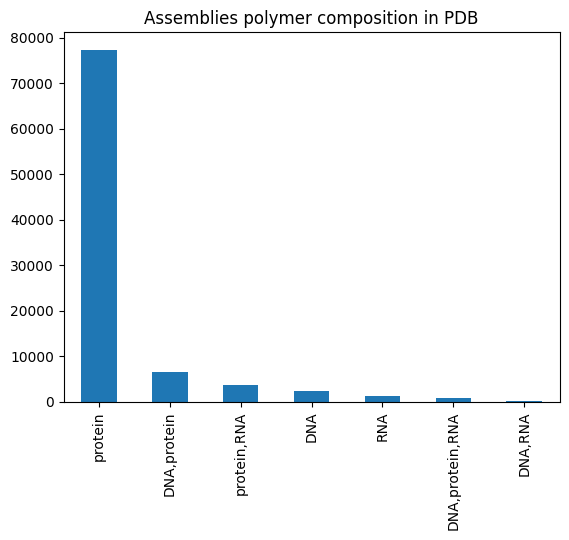

In [14]:
ax = assemblies_polymer_composition.plot(kind="bar")
ax.set_title("Assemblies polymer composition in PDB")

We can see that the vast majority of assemblies in the PDB are protein assemblies followed by DNA-protein and RNA-protein assemblies respectively.

## 1.3) Focusing on protein assemblies

Next, we will investigate some statistics of protein assemblies.

### 1.3.1) Creating protein-only assembly subset

We start by creating a data frame for protein assemblies.


In [15]:
# Create a new dataframe to represent protein assemblies
df_protein = df[df["ASSEMBLY_POLYMERS"] == "protein"].copy()
df_protein.head()

,HASH_ASSEMBLY_STRING,ASSEMBLY_STRING,PDB_COMPLEX_ID,COMPLEX_PORTAL_ID,ASSEMBLY_NAME,NAME_SOURCE,ASSEMBLIES,PREFERED_ASSEMBLIES,EXP_METHOD,SPECIES_NAME,NUM_ASSEMBLIES,NUM_PDB,hasProteinComponent,hasRNAComponent,hasDNAComponent,ASSEMBLY_POLYMERS
0,8314d71be12be24dca4d3578fa195f89,A0A003_2,PDB-CPX-100001,NaN,NAD-dependent epimerase/dehydratase domain-con...,protein name from UniProt,"6kv9_1,6kvc_1","6kv9_1,6kvc_1",Other,culture-collection:NRRL:B:12104 [[Streptomyces,2,2,True,False,False,protein
12,85b8916f3c47a9edbc46c0ea75bbe361,A0A010_2,PDB-CPX-100013,NaN,MoeN5,protein name from UniProt,"5b00_1,5b00_2,5b01_1,5b01_2,5b01_3,5b01_4,5b01_5","5b01_1,5b00_1",X-ray diffraction,culture-collection:NRRL:B:12104 [[Streptomyces,7,2,True,False,False,protein
13,39fbce3cc850c81966d45e2d1556cf6e,"A0A010_2,A0A010_2,P39476_2,P39476_2",PDB-CPX-100014,NaN,DNA-binding protein 7d and MoeN5,heterodimer,"5b02_1,5b02_2,5b03_1,5b03_2,5b0i_1,5b0i_2,5b0j...","5b0l_1,5b0m_4,5gwv_2,5b0i_1,6j8w_2,6j8v_2,5gww...","Other,X-ray diffraction",culture-collection:NRRL:B:12104 [[Streptomyces,26,11,True,False,False,protein
14,4a9d6ab84f75bc191c0700e7ac77fb7c,A0A011_2,PDB-CPX-100015,NaN,Geranylgeranylglyceryl/heptaprenylglyceryl pho...,protein name from UniProt,"3vk5_1,3vka_1,3vkb_1,3vkc_1,3vkd_1","3vka_1,3vkd_1,3vkb_1,3vkc_1,3vk5_1",X-ray diffraction,culture-collection:NRRL:B:12104 [[Streptomyces,5,5,True,False,False,protein
15,a443abb2485d89de4e76f1747c3683c3,A0A014C6J9_2,PDB-CPX-100016,NaN,DNA-binding response regulator,protein name from UniProt,6br7_1,6br7_1,Other,Acinetobacter sp.,1,1,True,False,False,protein


### 1.3.2) Assembly components mapped to UniProt accessions

Then, we check if the components in the protein assemblies are all mapped to UniProt accessions. Reasons why a protein may not be mapped to a UniProt accession include:

* Length limitation (sequence too short to map reliably)
* Type limitation (certain classes of proteins, such as antibodies, have no UniProt accessions

In [16]:
# Column to indicate whether all components in the protein assembly are mapped to UniProt
df_protein["hasAllUNPMapping"] = df_protein["ASSEMBLY_STRING"].apply(lambda x: ui.validate_uniprot(x, all))

In [17]:
# Number of protein assemblies with all components mapped to UniProt
mapped_protein_assemblies_all = df_protein[df_protein["hasAllUNPMapping"] == True]
mapped_protein_assemblies_all.head()

,HASH_ASSEMBLY_STRING,ASSEMBLY_STRING,PDB_COMPLEX_ID,COMPLEX_PORTAL_ID,ASSEMBLY_NAME,NAME_SOURCE,ASSEMBLIES,PREFERED_ASSEMBLIES,EXP_METHOD,SPECIES_NAME,NUM_ASSEMBLIES,NUM_PDB,hasProteinComponent,hasRNAComponent,hasDNAComponent,ASSEMBLY_POLYMERS,hasAllUNPMapping
0,8314d71be12be24dca4d3578fa195f89,A0A003_2,PDB-CPX-100001,NaN,NAD-dependent epimerase/dehydratase domain-con...,protein name from UniProt,"6kv9_1,6kvc_1","6kv9_1,6kvc_1",Other,culture-collection:NRRL:B:12104 [[Streptomyces,2,2,True,False,False,protein,True
12,85b8916f3c47a9edbc46c0ea75bbe361,A0A010_2,PDB-CPX-100013,NaN,MoeN5,protein name from UniProt,"5b00_1,5b00_2,5b01_1,5b01_2,5b01_3,5b01_4,5b01_5","5b01_1,5b00_1",X-ray diffraction,culture-collection:NRRL:B:12104 [[Streptomyces,7,2,True,False,False,protein,True
13,39fbce3cc850c81966d45e2d1556cf6e,"A0A010_2,A0A010_2,P39476_2,P39476_2",PDB-CPX-100014,NaN,DNA-binding protein 7d and MoeN5,heterodimer,"5b02_1,5b02_2,5b03_1,5b03_2,5b0i_1,5b0i_2,5b0j...","5b0l_1,5b0m_4,5gwv_2,5b0i_1,6j8w_2,6j8v_2,5gww...","Other,X-ray diffraction",culture-collection:NRRL:B:12104 [[Streptomyces,26,11,True,False,False,protein,True
14,4a9d6ab84f75bc191c0700e7ac77fb7c,A0A011_2,PDB-CPX-100015,NaN,Geranylgeranylglyceryl/heptaprenylglyceryl pho...,protein name from UniProt,"3vk5_1,3vka_1,3vkb_1,3vkc_1,3vkd_1","3vka_1,3vkd_1,3vkb_1,3vkc_1,3vk5_1",X-ray diffraction,culture-collection:NRRL:B:12104 [[Streptomyces,5,5,True,False,False,protein,True
15,a443abb2485d89de4e76f1747c3683c3,A0A014C6J9_2,PDB-CPX-100016,NaN,DNA-binding response regulator,protein name from UniProt,6br7_1,6br7_1,Other,Acinetobacter sp.,1,1,True,False,False,protein,True


#### 1.3.2.1) Every component mapped to UniProt accessions

In [18]:
# Calculate the percentage of protein assemblies with all components mapped to UniProt
print("Across the PDB, %i%% percent of protein assemblies have all of their components mapped to UniProt" % (len(mapped_protein_assemblies_all)/len(df_protein)*100))

Across the PDB, 77% percent of protein assemblies have all of their components mapped to UniProt


1.3.2.2) Any of the components mapped to UniProt accessions

In [19]:
# Column to indicate whether any one of the components in the protein assembly is mapped to UniProt
df_protein["hasAnyUNPMapping"] = df_protein["ASSEMBLY_STRING"].apply(lambda x: ui.validate_uniprot(x, any))

In [20]:
# Number of protein assemblies with at least one component mapped to UniProt
mapped_protein_assemblies_any = df_protein[df_protein["hasAnyUNPMapping"] == True]
mapped_protein_assemblies_any.head()

,HASH_ASSEMBLY_STRING,ASSEMBLY_STRING,PDB_COMPLEX_ID,COMPLEX_PORTAL_ID,ASSEMBLY_NAME,NAME_SOURCE,ASSEMBLIES,PREFERED_ASSEMBLIES,EXP_METHOD,SPECIES_NAME,NUM_ASSEMBLIES,NUM_PDB,hasProteinComponent,hasRNAComponent,hasDNAComponent,ASSEMBLY_POLYMERS,hasAllUNPMapping,hasAnyUNPMapping
0,8314d71be12be24dca4d3578fa195f89,A0A003_2,PDB-CPX-100001,NaN,NAD-dependent epimerase/dehydratase domain-con...,protein name from UniProt,"6kv9_1,6kvc_1","6kv9_1,6kvc_1",Other,culture-collection:NRRL:B:12104 [[Streptomyces,2,2,True,False,False,protein,True,True
12,85b8916f3c47a9edbc46c0ea75bbe361,A0A010_2,PDB-CPX-100013,NaN,MoeN5,protein name from UniProt,"5b00_1,5b00_2,5b01_1,5b01_2,5b01_3,5b01_4,5b01_5","5b01_1,5b00_1",X-ray diffraction,culture-collection:NRRL:B:12104 [[Streptomyces,7,2,True,False,False,protein,True,True
13,39fbce3cc850c81966d45e2d1556cf6e,"A0A010_2,A0A010_2,P39476_2,P39476_2",PDB-CPX-100014,NaN,DNA-binding protein 7d and MoeN5,heterodimer,"5b02_1,5b02_2,5b03_1,5b03_2,5b0i_1,5b0i_2,5b0j...","5b0l_1,5b0m_4,5gwv_2,5b0i_1,6j8w_2,6j8v_2,5gww...","Other,X-ray diffraction",culture-collection:NRRL:B:12104 [[Streptomyces,26,11,True,False,False,protein,True,True
14,4a9d6ab84f75bc191c0700e7ac77fb7c,A0A011_2,PDB-CPX-100015,NaN,Geranylgeranylglyceryl/heptaprenylglyceryl pho...,protein name from UniProt,"3vk5_1,3vka_1,3vkb_1,3vkc_1,3vkd_1","3vka_1,3vkd_1,3vkb_1,3vkc_1,3vk5_1",X-ray diffraction,culture-collection:NRRL:B:12104 [[Streptomyces,5,5,True,False,False,protein,True,True
15,a443abb2485d89de4e76f1747c3683c3,A0A014C6J9_2,PDB-CPX-100016,NaN,DNA-binding response regulator,protein name from UniProt,6br7_1,6br7_1,Other,Acinetobacter sp.,1,1,True,False,False,protein,True,True


In [21]:
# Calculate the percentage of protein assemblies with at least one component mapped to UniProt
print("Across the PDB archive %i%% of the protein-only assemblies have at least one component mapped to UniProt" % (len(mapped_protein_assemblies_any)/len(df_protein)*100))

Across the PDB archive 90% of the protein-only assemblies have at least one component mapped to UniProt


## 2) Variation of stoichiometry in assemblies in the PDB

Structures in the PDB archive are determined to investigate a specific scientific problem. Consequently, a PDB structure does not always represent the biological complex. For example, PDB entry [1abw](https://www.ebi.ac.uk/pdbe/entry/pdb/1abw) contains a human haemoglobin trimer where two copies of the alpha subunit are linked together. This trimer represents a deviation from the biological heterotetrameric state of haemoglobin. In this section of the notebook, we analyse UniProt accessions in which the assemblies exist with different stoichiometries.

### 2.1) Classification

First, we classify the assemblies into three types:
* monomeric
* homomeric
* heteromeric

A monomeric assembly is defined as an assembly that consists of a single subunit. Homomeric assemblies are formed by repeated units of a single subunit while heteromeric assemblies are composed of multiple distinct subunits. We limited our stoichiometry analysis to homomeric protein assemblies that have all components mapped to UniProt.

In [22]:
# Column to indicate whether a protein assembly is monomeric, homomeric or heteromeric
df_protein["ASSEMBLY_TYPE"] = df_protein["ASSEMBLY_STRING"].apply(lambda x: ui.get_assembly_type(x))

In [23]:
# Create a dataframe to represent monomeric protein assemblies
df_protein_monomeric = df_protein[df_protein["ASSEMBLY_TYPE"] == "monomeric"]
# Create a dataframe to represent homomeric protein assemblies
df_protein_homomeric = df_protein[df_protein["ASSEMBLY_TYPE"] == "homomeric"]
# Create a dataframe to represent heteromeric protein assemblies
df_protein_heteromeric = df_protein[df_protein["ASSEMBLY_TYPE"] == "heteromeric"]

# Calculate the percentage of monomeric protein assemblies
percentage_monomeric_assemblies = (len(df_protein_monomeric)/len(df_protein))*100
# Calculate the percentage of homomeric protein assemblies
percentage_homomeric_assemblies = (len(df_protein_homomeric)/len(df_protein))*100
# Calculate the percentage of heteromeric protein assemblies
percentage_heteromeric_assemblies = (len(df_protein_heteromeric)/len(df_protein))*100

In [24]:
print("Out of all the assemblies in the PDB, %i%% are monomeric, %i%% are homomeric and %i%% are heteromeric." % (
    percentage_monomeric_assemblies,
    percentage_homomeric_assemblies,
    percentage_heteromeric_assemblies
))

Out of all the assemblies in the PDB, 33% are monomeric, 33% are homomeric and 33% are heteromeric.


In [25]:
df_protein_heteromeric

,HASH_ASSEMBLY_STRING,ASSEMBLY_STRING,PDB_COMPLEX_ID,COMPLEX_PORTAL_ID,ASSEMBLY_NAME,NAME_SOURCE,ASSEMBLIES,PREFERED_ASSEMBLIES,EXP_METHOD,SPECIES_NAME,NUM_ASSEMBLIES,NUM_PDB,hasProteinComponent,hasRNAComponent,hasDNAComponent,ASSEMBLY_POLYMERS,hasAllUNPMapping,hasAnyUNPMapping,ASSEMBLY_TYPE
13,39fbce3cc850c81966d45e2d1556cf6e,"A0A010_2,A0A010_2,P39476_2,P39476_2",PDB-CPX-100014,NaN,DNA-binding protein 7d and MoeN5,heterodimer,"5b02_1,5b02_2,5b03_1,5b03_2,5b0i_1,5b0i_2,5b0j...","5b0l_1,5b0m_4,5gwv_2,5b0i_1,6j8w_2,6j8v_2,5gww...","Other,X-ray diffraction",culture-collection:NRRL:B:12104 [[Streptomyces,26,11,True,False,False,protein,True,True,heteromeric
22,f4c44eb7a88d77df2d16592a433f4da4,"A0A022MRT4_1,A0A022MRT4_1",PDB-CPX-100023,NaN,AMP-dependent synthetase/ligase domain-contain...,protein name from UniProt,"6siw_1,6tm4_1","6tm4_1,6siw_1",Other,Streptomyces sp.,2,2,True,False,False,protein,True,True,heteromeric
26,b181cacca3c24b39d0b36f18bf2df31a,"A0A023FDY8_1,P13500_1",PDB-CPX-100027,NaN,Evasin P974 and C-C motif chemokine 2,heterodimer,7so0_1,7so0_1,Other,Cayenne tick,1,1,True,False,False,protein,True,True,heteromeric
27,3d22826ab542715efad1759281b1a1ee,"A0A023FDY8_1,P80075_1,P80075_1,P80098_1,P80098_1",PDB-CPX-100028,NaN,NaN,NaN,"7s59_1,7s59_2",7s59_1,Other,Humo sapiens,2,1,True,False,False,protein,True,True,heteromeric
28,6fecbfd42b482420704db030e5d1342f,"A0A023FDY8_1,P80098_1",PDB-CPX-100029,NaN,Evasin P974 and C-C motif chemokine 7,heterodimer,"7s58_1,7s58_2,7s58_3,7s58_4",7s58_1,Other,Cayenne tick,4,1,True,False,False,protein,True,True,heteromeric
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100625,116a7a53f3c693000af26da20b37cc8d,"antibody_8d5p_1_1,antibody_8d5p_2_1",PDB-CPX-200626,NaN,NaN,NaN,"8d5p_1,8d5p_2",8d5p_1,Other,None,2,1,True,False,False,protein,False,False,heteromeric
100626,80f27bdf7ddaa60835f8f0968208d528,"antibody_8ek6_1_1,antibody_8ek6_2_1",PDB-CPX-200627,NaN,NaN,NaN,8ek6_1,8ek6_1,Other,None,1,1,True,False,False,protein,False,False,heteromeric
100627,5224dc0a715c4b43daf893919a926cc8,"antibody_8ekh_1_1,antibody_8ekh_2_1",PDB-CPX-200628,NaN,NaN,NaN,8ekh_1,8ekh_1,Other,None,1,1,True,False,False,protein,False,False,heteromeric
100628,a1b7fcd233f14686de97ae4b60deba88,"antibody_8fab_1_1,antibody_8fab_2_1",PDB-CPX-200629,NaN,NaN,NaN,"8fab_1,8fab_2",8fab_1,X-ray diffraction,None,2,1,True,False,False,protein,False,False,heteromeric


### 2.1) Homomeric protein assemblies

Next, we will investigate the homomeric protein assemblies.

In [117]:
# Create a dataframe to represent homomeric protein assemblies with all components mapped to UniProt
df_protein_homomeric_mapped = df_protein_homomeric[(df_protein_homomeric["hasAllUNPMapping"] == True)]
df_protein_homomeric_mapped
# df_protein_homomeric.to_csv("homomeric_assemblies.csv", index=False)

,HASH_ASSEMBLY_STRING,ASSEMBLY_STRING,PDB_COMPLEX_ID,COMPLEX_PORTAL_ID,ASSEMBLY_NAME,NAME_SOURCE,ASSEMBLIES,PREFERED_ASSEMBLIES,EXP_METHOD,SPECIES_NAME,NUM_ASSEMBLIES,NUM_PDB,hasProteinComponent,hasRNAComponent,hasDNAComponent,ASSEMBLY_POLYMERS,hasAllUNPMapping,hasAnyUNPMapping,ASSEMBLY_TYPE
0,8314d71be12be24dca4d3578fa195f89,A0A003_2,PDB-CPX-100001,NaN,NAD-dependent epimerase/dehydratase domain-con...,protein name from UniProt,"6kv9_1,6kvc_1","6kv9_1,6kvc_1",Other,culture-collection:NRRL:B:12104 [[Streptomyces,2,2,True,False,False,protein,True,True,homomeric
12,85b8916f3c47a9edbc46c0ea75bbe361,A0A010_2,PDB-CPX-100013,NaN,MoeN5,protein name from UniProt,"5b00_1,5b00_2,5b01_1,5b01_2,5b01_3,5b01_4,5b01_5","5b01_1,5b00_1",X-ray diffraction,culture-collection:NRRL:B:12104 [[Streptomyces,7,2,True,False,False,protein,True,True,homomeric
14,4a9d6ab84f75bc191c0700e7ac77fb7c,A0A011_2,PDB-CPX-100015,NaN,Geranylgeranylglyceryl/heptaprenylglyceryl pho...,protein name from UniProt,"3vk5_1,3vka_1,3vkb_1,3vkc_1,3vkd_1","3vka_1,3vkd_1,3vkb_1,3vkc_1,3vk5_1",X-ray diffraction,culture-collection:NRRL:B:12104 [[Streptomyces,5,5,True,False,False,protein,True,True,homomeric
15,a443abb2485d89de4e76f1747c3683c3,A0A014C6J9_2,PDB-CPX-100016,NaN,DNA-binding response regulator,protein name from UniProt,6br7_1,6br7_1,Other,Acinetobacter sp.,1,1,True,False,False,protein,True,True,homomeric
16,c389bc2dd3f377c1ce88c5b65b04f541,A0A014M399_2,PDB-CPX-100017,NaN,DAC domain-containing protein,protein name from UniProt,"7dfx_1,7dg0_1","7dg0_1,7dfx_1",Other,Mycoplasma ovipneumoniae,2,2,True,False,False,protein,True,True,homomeric
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99009,ba2749960f8ee9afff9cace4e0693815,X5K3J9_2,PDB-CPX-199010,NaN,HTH gntR-type domain-containing protein,protein name from UniProt,6az6_1,6az6_1,Other,strain ND,1,1,True,False,False,protein,True,True,homomeric
99010,492c4015b0321a5a5d3246bf247562c2,X5KA67_2,PDB-CPX-199011,NaN,Asparagine--tRNA ligase,protein name from UniProt,"6pqh_1,6pqh_2",6pqh_1,Other,DSM 15670,2,1,True,False,False,protein,True,True,homomeric
99013,ac23653f4d0ae5b66ba7cad8159adfa5,X5MEI1_8,PDB-CPX-199014,NaN,3'-5' exonuclease domain-containing protein,protein name from UniProt,"7mpo_1,7mpp_1","7mpp_1,7mpo_1",Other,DSM 28221,2,2,True,False,False,protein,True,True,homomeric
99014,11cc7dd7f3358c7d60b38bd529c9c2c7,X7XQY2_4,PDB-CPX-199015,NaN,Enoyl-[acyl-carrier-protein] reductase [NADH],protein name from UniProt,7kxa_1,7kxa_1,Other,Mycobacterium kansasii,1,1,True,False,False,protein,True,True,homomeric


Show the top 10 species of the homomeric assemblies

In [123]:
homomeric_species_count = df_protein_homomeric_mapped["SPECIES_NAME"].value_counts().head(10)
homomeric_species_count

Humo sapiens                  2760
Escherichia coli              1118
transgenic mice                523
Pseudomonas aeruginosa         471
Mycobacterium tuberculosis     462
Saccharomyces cerevisiae       378
Bacillus subtilis              377
Thermus thermophilus           341
Arabis thaliana                320
Staphylococcus aureus          274
Name: SPECIES_NAME, dtype: int64

Text(0.5, 1.0, 'Top 10 species homomeric assemblies')

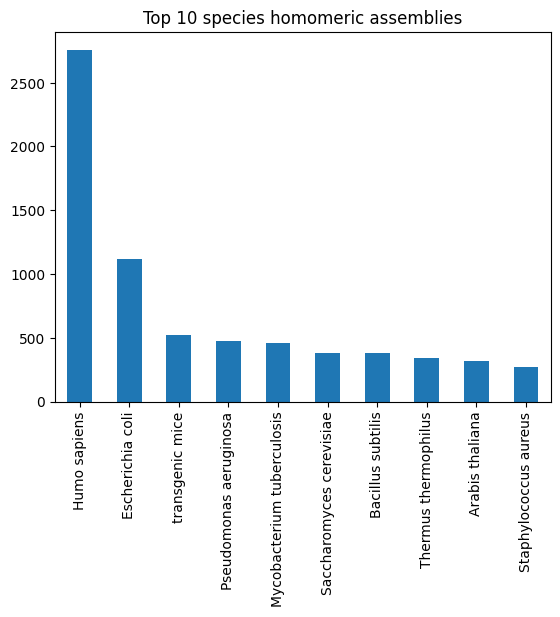

In [122]:
hx = homomeric_species_count.plot(kind="bar")
hx.set_title("Top 10 species homomeric assemblies")

In [27]:
# Calculate the percentage of homomeric protein assemblies that have all components mapped to UniProt
percentage_homomeric_assemblies_mapped = (len(df_protein_homomeric_mapped)/len(df_protein_homomeric))*100

In [28]:
print("%i%% of the homomeric protein assemblies have all their components mapped to UniProt accession." % percentage_homomeric_assemblies_mapped)

91% of the homomeric protein assemblies have all their components mapped to UniProt accession.


We then create a list of assembly composition strings, and group them by UniProt accessions.

In [29]:
# Create a list of UniProt accessions with stoichiometry in the homomeric assemblies
homomeric_assembly_strings = df_protein_homomeric_mapped["ASSEMBLY_STRING"].tolist()

In [30]:
# Group the UniProt accessions in homomeric assemblies
homomeric_grouped_UNP_accessions = ui.group_UniProt_accessions(homomeric_assembly_strings)
print ("There are %i groups." % len(homomeric_grouped_UNP_accessions))

There are 21597 groups.


Next, we keep only those groups where more than 1 stoichiometry numbers are present.

In [31]:
# Only keep UniProt accessions that display 2 or more stoichiometry number
homomeric_UNP_accessions_with_muliple_stoic = {k: sorted([int(x) for x in grp]) for k, grp in homomeric_grouped_UNP_accessions.items() if len(grp) > 1}
# Number of UniProt accessions with multiple stoichiometry numbers
homomeric_UNP_accession_stoic_count = len(homomeric_UNP_accessions_with_muliple_stoic)

In [32]:
print("There are %i UniProt accessions that exist in different stoichiometries in homomeric assemblies" % homomeric_UNP_accession_stoic_count)

There are 1324 UniProt accessions that exist in different stoichiometries in homomeric assemblies


In [33]:
# Count the stoichiometry number for UniProt accessions with two or more stoichiometries
homomeric_UNP_accessions_with_multiple_stoic_count = [(k, len(grp)) for k, grp in homomeric_UNP_accessions_with_muliple_stoic.items()]

In [34]:
# Sort the count of stoichiometry number in descending order
sorted_homomeric_UNP_accessions_with_multiple_stoic_count = sorted(homomeric_UNP_accessions_with_multiple_stoic_count, key=lambda x: x[1], reverse=True)

In [35]:
# Show the top 10 UniProt accessions with highest stoichiometry number count
sorted_homomeric_UNP_accessions_with_multiple_stoic_count[:13]

[('P05067', 12),
 ('P68135', 10),
 ('P10636', 8),
 ('P10997', 8),
 ('P37840', 8),
 ('B2J6D9', 7),
 ('P02766', 7),
 ('P41784', 7),
 ('Q13148', 7),
 ('P03354', 6),
 ('P04156', 6),
 ('P0ABE7', 6),
 ('P12493', 6)]

### 2.2) Heteromeric protein assemblies

Now, we will investigate the heteromeric protein assemblies.

In [36]:
# Create a dataframe to represent heteromeric protein assemblies with all components mapped to UniProt
df_protein_heteromeric_mapped = df_protein_heteromeric[(df_protein_heteromeric["hasAllUNPMapping"] == True)]
df_protein_heteromeric_mapped.head()

,HASH_ASSEMBLY_STRING,ASSEMBLY_STRING,PDB_COMPLEX_ID,COMPLEX_PORTAL_ID,ASSEMBLY_NAME,NAME_SOURCE,ASSEMBLIES,PREFERED_ASSEMBLIES,EXP_METHOD,SPECIES_NAME,NUM_ASSEMBLIES,NUM_PDB,hasProteinComponent,hasRNAComponent,hasDNAComponent,ASSEMBLY_POLYMERS,hasAllUNPMapping,hasAnyUNPMapping,ASSEMBLY_TYPE
13,39fbce3cc850c81966d45e2d1556cf6e,"A0A010_2,A0A010_2,P39476_2,P39476_2",PDB-CPX-100014,NaN,DNA-binding protein 7d and MoeN5,heterodimer,"5b02_1,5b02_2,5b03_1,5b03_2,5b0i_1,5b0i_2,5b0j...","5b0l_1,5b0m_4,5gwv_2,5b0i_1,6j8w_2,6j8v_2,5gww...","Other,X-ray diffraction",culture-collection:NRRL:B:12104 [[Streptomyces,26,11,True,False,False,protein,True,True,heteromeric
22,f4c44eb7a88d77df2d16592a433f4da4,"A0A022MRT4_1,A0A022MRT4_1",PDB-CPX-100023,NaN,AMP-dependent synthetase/ligase domain-contain...,protein name from UniProt,"6siw_1,6tm4_1","6tm4_1,6siw_1",Other,Streptomyces sp.,2,2,True,False,False,protein,True,True,heteromeric
26,b181cacca3c24b39d0b36f18bf2df31a,"A0A023FDY8_1,P13500_1",PDB-CPX-100027,NaN,Evasin P974 and C-C motif chemokine 2,heterodimer,7so0_1,7so0_1,Other,Cayenne tick,1,1,True,False,False,protein,True,True,heteromeric
27,3d22826ab542715efad1759281b1a1ee,"A0A023FDY8_1,P80075_1,P80075_1,P80098_1,P80098_1",PDB-CPX-100028,NaN,NaN,NaN,"7s59_1,7s59_2",7s59_1,Other,Humo sapiens,2,1,True,False,False,protein,True,True,heteromeric
28,6fecbfd42b482420704db030e5d1342f,"A0A023FDY8_1,P80098_1",PDB-CPX-100029,NaN,Evasin P974 and C-C motif chemokine 7,heterodimer,"7s58_1,7s58_2,7s58_3,7s58_4",7s58_1,Other,Cayenne tick,4,1,True,False,False,protein,True,True,heteromeric


In [37]:
# Calculate the percentage of heteromeric protein assemblies that have all components mapped to UniProt
percentage_heteromeric_assemblies_mapped = (len(df_protein_heteromeric_mapped)/len(df_protein_heteromeric))*100

In [38]:
print("%i%% of the heteromeric protein assemblies have all their components mapped to UniProt accession." % percentage_heteromeric_assemblies_mapped)

53% of the heteromeric protein assemblies have all their components mapped to UniProt accession.


In [39]:
# Create a list of UniProt accessions with stoichiometry in the heteromeric assemblies
heteromeric_assembly_strings = df_protein_heteromeric_mapped["ASSEMBLY_STRING"].tolist()
heteromeric_assembly_components = [assembly.split(",") for assembly in heteromeric_assembly_strings]
heteromeric_assembly_components = [item for sublist in heteromeric_assembly_components for item in sublist] 
heteromeric_assembly_components = list(set(heteromeric_assembly_components))

In [40]:
# Group the UniProt accessions in the heteromeric assemblies
heteromeric_grouped_UNP_accessions = ui.group_UniProt_accessions(heteromeric_assembly_components)
print ("There are %i groups." % len(heteromeric_grouped_UNP_accessions))

There are 17138 groups.


Next, we keep only those groups where more than 1 stoichiometry numbers are present.

In [41]:
# Only keep UniProt accessions that display 2 or more stoichiometry number
heteromeric_UNP_accessions_with_muliple_stoic = {k: sorted([int(x) for x in grp]) for k, grp in heteromeric_grouped_UNP_accessions.items() if len(grp) > 1}
# Number of UniProt accessions with multiple stoichiometry numbers
heteromeric_UNP_accession_stoic_count = len(heteromeric_UNP_accessions_with_muliple_stoic)

In [42]:
print("There are %i UniProt accessions that exist in different stoichiometries in heteromeric assemblies" % heteromeric_UNP_accession_stoic_count)

There are 3006 UniProt accessions that exist in different stoichiometries in heteromeric assemblies


In [43]:
# Count the stoichiometry number for UniProt accessions with two or more stoichiometries
heteromeric_UNP_accessions_with_multiple_stoic_count = [(k, len(grp)) for k, grp in heteromeric_UNP_accessions_with_muliple_stoic.items()]

In [44]:
# Sort the count of stoichiometry number in descending order
sorted_heteromeric_UNP_accessions_with_multiple_stoic_count = sorted(heteromeric_UNP_accessions_with_multiple_stoic_count, key=lambda x: x[1], reverse=True)

In [45]:
# Show the top 10 UniProt accessions with highest stoichiometry number count
sorted_heteromeric_UNP_accessions_with_multiple_stoic_count[:10]

[('P02554', 14),
 ('P68135', 13),
 ('Q2XVP4', 12),
 ('P42212', 9),
 ('P10636', 9),
 ('Q96CW5', 8),
 ('P54274', 8),
 ('P03069', 7),
 ('Q08AG7', 7),
 ('Q3J1A4', 7)]

In [46]:
print(heteromeric_UNP_accessions_with_muliple_stoic)

{'P01647': [1, 2], 'O73947': [1, 3], 'P01902': [1, 2], 'O50336': [14, 16], 'P30260': [1, 2], 'Q8WSF8': [1, 2, 4, 5, 10], 'P25445': [1, 2], 'P0C077': [1, 6], 'P9WPX3': [1, 2], 'Q9C0C9': [1, 2], 'O88951': [1, 2], 'P0CE47': [1, 2], 'P04578': [1, 2, 3], 'Q6HAD8': [12, 24], 'O75367': [1, 2], 'Q8N355': [1, 3], 'P60849': [1, 2], 'Q8GI16': [2, 3], 'P22629': [1, 2, 3, 4], 'P72986': [1, 3], 'Q00518': [1, 3], 'P41783': [23, 24], 'P02699': [1, 2], 'Q13315': [1, 2], 'S7V493': [1, 2, 6], 'O75475': [1, 2, 4], 'P06756': [1, 2, 60], 'P58154': [1, 3, 4, 5], 'P42212': [1, 2, 3, 4, 8, 11, 15, 31, 180], 'P00129': [1, 2], 'P98170': [1, 2], 'F1LW30': [1, 2, 4], 'P49023': [1, 2, 3], 'P46976': [3, 4, 6], 'P27694': [1, 2, 3, 4], 'P05161': [1, 2], 'Q2V2P9': [1, 2], 'P04439': [1, 2, 6], 'Q8ECH7': [1, 2], 'Q38610': [3, 9], 'G0RYI5': [3, 6], 'Q9H3M7': [1, 2, 4, 8], 'Q9NP97': [2, 4], 'A3DCU2': [1, 2], 'Q05093': [2, 4], 'P22301': [1, 2], 'P0A221': [16, 24], 'P49303': [1, 60], 'P53816': [1, 2], 'O14727': [1, 3, 4, 6, 

In [47]:
added, removed, modified, same = ui.dict_compare(homomeric_UNP_accessions_with_muliple_stoic, heteromeric_UNP_accessions_with_muliple_stoic)

In [48]:
print("There are %i UniProt accessions unique for homomeric assemblies" % len(added))

There are 1137 UniProt accessions unique for homomeric assemblies


In [49]:
print("There are %i UniProt accessions unique for heteromeric assemblies" % len(removed))

There are 2819 UniProt accessions unique for heteromeric assemblies


In [50]:
print("There are %i UniProt accessions that are common to both homomeric and heteromeric assemblies with the same stoichiometries" % len(same))

There are 11 UniProt accessions that are common to both homomeric and heteromeric assemblies with the same stoichiometries


In [51]:
print("There are %i UniProt accessions that are common to both homomeric and heteromeric assemblies with varying stoichiometries" % len(modified))

There are 176 UniProt accessions that are common to both homomeric and heteromeric assemblies with varying stoichiometries


In [52]:
modified

{'Q15109': ([2, 4], [1, 2]),
 'Q9WXS1': ([3, 60], [1, 60]),
 'P02511': ([2, 6, 12, 24], [1, 2]),
 'Q14457': ([2, 3], [1, 2, 3]),
 'P12493': ([2, 3, 6, 18, 24, 378], [1, 2, 6]),
 'P0DTC9': ([2, 4, 12, 16, 18], [1, 2]),
 'P12367': ([2, 8], [1, 2]),
 'Q14790': ([2, 9], [1, 2]),
 'Q9Y572': ([3, 5], [1, 4]),
 'Q05097': ([2, 4], [1, 3]),
 'P42212': ([2, 4, 5, 6, 7, 8], [1, 2, 3, 4, 8, 11, 15, 31, 180]),
 'P06734': ([2, 3], [1, 2]),
 'P29466': ([2, 8], [1, 2, 4]),
 'P69783': ([2, 3], [1, 2, 4]),
 'P62987': ([2, 4], [1, 2, 3, 5]),
 'Q7Z3B4': ([4, 20], [2, 32]),
 'P04591': ([6, 18], [1, 2, 12]),
 'P00720': ([2, 3, 4, 6], [1, 2]),
 'P00044': ([2, 4], [1, 2]),
 'Q05086': ([2, 3], [1, 2, 3]),
 'P61956': ([2, 3], [1, 2, 4]),
 'O66529': ([60, 180, 360], [120, 180, 240]),
 'Q9NR28': ([2, 4], [1, 2, 6]),
 'P0AEX9': ([2, 3, 4], [1, 2, 3, 4, 12]),
 'P00441': ([2, 3, 8, 10, 20], [1, 2]),
 'P77398': ([2, 6], [4, 6]),
 'P41783': ([6, 24], [23, 24]),
 'P01112': ([2, 3, 4], [1, 2, 4]),
 'Q9C005': ([2, 4], [2

## 3) Sub-assembly analysis

A biological assembly can consist of multiple components where each component can have varying stoichiometry. This is best illustrated by the ribosome which is the molecular machine responsible for protein synthesis in every living cell. The ribosome is made up of two ribosomal subunits (small and large ribosomal subunits) and can bind multiple tRNAs (1-3 tRNAs), mRNA, and diverse protein factors. The binding of tRNAs and the various protein factors can induce the ribosome to undergo large-scale conformational changes which affects how the ribosome functions. As such, the ability to identify the sub- and super-assemblies of a biological assembly is key in identifying the contribution of each component to the function of the whole assembly and the relationships that exist between the components.

We define sub- and super-assembly using the composition and stoichiometry data. We defined a sub-assembly as an assembly where all components map to UniProt accessions and where these components are also present in another assembly. For example, PDB entry [5jdo](https://pdbe.org/5jdo) contains haemoglobin (UniProt [P68871](https://pdbe-kb.org/proteins/P68871) and UniProt [P69905](https://pdbe-kb.org/proteins/P69905)) bound to the haptoglobin-haemoglobin receptor (UniProt [G0UVW6](https://pdbe-kb.org/proteins/G0UVW6)). A sub-assembly of this assembly is haemoglobin. We defined a super-assembly as an assembly that has all the same elements of another assembly plus additional members. Again, all members must map to a UniProt accession. In the example above,  PDB entry [5jdo](https://pdbe.org/5jdo is a super-assembly of haemoglobin.

### 3.1) Reading in the data

In [53]:
df_subassemblies = pd.read_csv("data/subassemblies_data.csv")
df_subassemblies.head()

,SUBASSEMBLY_STRING,SUBASSEMBLY_ID,SUBASSEMBLY_NAME,SUBASSEMBLIES,SUPERASSEMBLY_STRING,SUPERASSEMBLY_ID,SUPERASSEMBLY_NAME,SUPERASSEMBLIES
0,A0A010_2,PDB-CPX-100013,MoeN5,"5b00_1,5b00_2,5b01_1,5b01_2,5b01_3,5b01_4,5b01_5","A0A010_2,A0A010_2,P39476_2,P39476_2",PDB-CPX-100014,DNA-binding protein 7d and MoeN5,"5b02_1,5b02_2,5b03_1,5b03_2,5b0i_1,5b0i_2,5b0j..."
1,A0A023NA98_1,PDB-CPX-100044,MARTX,7d5y_1,"A0A023NA98_1,A0A023NA98_1,P07737_1,P0AEX9_1,P0...",PDB-CPX-100045,NaN,7p1h_1
2,"A0A024B7W1_15,A0A024B7W1_15",PDB-CPX-100064,RNA-directed RNA polymerase NS5,"5ire_3,5iz7_3,6co8_3,6lnu_3","A0A024B7W1_15,A0A024B7W1_15,A0A0B4L3F2_15,O118...",PDB-CPX-100066,NaN,5u4w_3
3,"A0A024B7W1_18,A0A024B7W1_18",PDB-CPX-100078,RNA-directed RNA polymerase NS5,"5ire_4,5iz7_4,6co8_4,6lnu_4","A0A024B7W1_18,A0A024B7W1_18,A0A0B4L3F2_18,O118...",PDB-CPX-100080,NaN,5u4w_4
4,"A0A024B7W1_180,A0A024B7W1_180",PDB-CPX-100092,RNA-directed RNA polymerase NS5,"5ire_1,5iz7_1,6co8_1,6lnu_1","A0A024B7W1_180,A0A024B7W1_180,A0A0B4L3F2_180,O...",PDB-CPX-100094,NaN,5u4w_1


In [54]:
print("There are %i unique sub-assemblies, and %i unique super-assemblies in the PDB with all components in the assemblies mapped to UniProt." % (
    df_subassemblies["SUBASSEMBLY_ID"].nunique(),
    df_subassemblies["SUPERASSEMBLY_ID"].nunique()
))

There are 3745 unique sub-assemblies, and 6982 unique super-assemblies in the PDB with all components in the assemblies mapped to UniProt.


### 3.2) Matching sub- and super-assemblies

We can match sub- and super-assemblies.

In [55]:
subassembly_list = df_subassemblies["SUBASSEMBLY_ID"].tolist()
superassembly_list = df_subassemblies["SUPERASSEMBLY_ID"].tolist()
subassembly_pairs = list(zip(subassembly_list, superassembly_list))

In [56]:
subassembly_pairs[:10]

[('PDB-CPX-100013', 'PDB-CPX-100014'),
 ('PDB-CPX-100044', 'PDB-CPX-100045'),
 ('PDB-CPX-100064', 'PDB-CPX-100066'),
 ('PDB-CPX-100078', 'PDB-CPX-100080'),
 ('PDB-CPX-100092', 'PDB-CPX-100094'),
 ('PDB-CPX-100116', 'PDB-CPX-100118'),
 ('PDB-CPX-100163', 'PDB-CPX-100164'),
 ('PDB-CPX-100163', 'PDB-CPX-100165'),
 ('PDB-CPX-100164', 'PDB-CPX-100165'),
 ('PDB-CPX-100284', 'PDB-CPX-100285')]

In [57]:
grouped_subassemblies, grouped_superassemblies = ui.group_subassemblies(subassembly_pairs)

In [58]:
# Only keep assemblies having at least two super-assemblies
assemblies_with_muliple_superassembly = {k: grp for k, grp in grouped_subassemblies.items() if len(grp) > 1}
print("Only %i assemblies have 2 or more super-assemblies" % len(assemblies_with_muliple_superassembly))

Only 1141 assemblies have 2 or more super-assemblies


### 3.3) Finding the assemblies in the PDB which have the highest number of super-assemblies

In [59]:
# Count the number of superassemblies
superassemblies_count = [(k, len(grp)) for k, grp in assemblies_with_muliple_superassembly.items()]

# Sort the count of superassemblies in descending order
sorted_superassemblies_count = sorted(superassemblies_count, key=lambda x: x[1], reverse=True)

# Show the top 10 entries with the highest number of superassemblies
sorted_superassemblies_count[:10]

# Get the PDB Complex ID for the top 10 entries
top_ten_entries_ids = [x[0] for x in sorted_superassemblies_count[:10]]

# Show the assemblies data for the top 10 entries
df[df["PDB_COMPLEX_ID"].isin(top_ten_entries_ids)]

,HASH_ASSEMBLY_STRING,ASSEMBLY_STRING,PDB_COMPLEX_ID,COMPLEX_PORTAL_ID,ASSEMBLY_NAME,NAME_SOURCE,ASSEMBLIES,PREFERED_ASSEMBLIES,EXP_METHOD,SPECIES_NAME,NUM_ASSEMBLIES,NUM_PDB,hasProteinComponent,hasRNAComponent,hasDNAComponent,ASSEMBLY_POLYMERS
33369,2f8af4d644d61581126b2e78a0dab619,P00720_1,PDB-CPX-133370,NaN,Endolysin,protein name from UniProt,"102l_1,103l_1,104l_1,104l_2,107l_1,108l_1,109l...","1l79_1,2b6x_1,1li3_1,168l_1,1l42_1,3c8r_1,1d3j...","NMR,Other,X-ray diffraction",Enterobacteria phage,684,608,True,False,False,protein
33480,34994857885a86309e94ceddaa3a29d1,P00734_1,PDB-CPX-133481,NaN,Thrombin light chain,protein name from UniProt,"1jwt_1,1mh0_1,1mh0_2,3nxp_1,3sqe_1,3sqh_1,4h6t...","3sqe_1,5edm_1,1jwt_1,4h6t_1,5z5w_1,1mh0_1,6bjr...","Other,X-ray diffraction",Humo sapiens,21,17,True,False,False,protein
35370,6783d9c622188cd1f0d5999328f1dc25,P01887_1,PDB-CPX-135371,NaN,Beta-2-microglobulin,protein name from UniProt,6i8c_1,6i8c_1,Other,transgenic mice,1,1,True,False,False,protein
38519,550ca8ff8255ffafd03c46e8acd42e04,"P04439_1,P61769_1",PDB-CPX-138520,NaN,Beta-2-microglobulin and HLA class I histocomp...,heterodimer,"1hla_1,2hla_1,3hla_1","3hla_1,1hla_1,2hla_1",X-ray diffraction,Humo sapiens,3,3,True,False,False,protein
43373,54f7b8f35c9d3ab448024f66d6c1246d,P0AEX9_1,PDB-CPX-143374,NaN,Maltose/maltodextrin-binding periplasmic protein,protein name from UniProt,"1a7l_1,1a7l_2,1a7l_3,1anf_1,1dmb_1,1ez9_1,1ez9...","1fqd_1,1mpb_1,7fbc_1,2n45_1,1lax_1,1fqb_1,5gxt...","NMR,Other,X-ray diffraction",Escherichia coli,103,75,True,False,False,protein
44094,28967121c8f74380240e5c737912e067,P0CG47_1,PDB-CPX-144095,NaN,Ubiquitin,protein name from UniProt,"2msg_1,4wzp_1,4wzp_2,4wzp_3,4wzp_4,4wzp_5,4wzp...","6kox_1,5tof_1,5zd0_1,6kow_1,5m93_2,6qf8_1,5k9p...","NMR,Other,X-ray diffraction",Humo sapiens,36,21,True,False,False,protein
44187,e5b1afb546457c70e8cf8d8c44358a55,P0CG48_1,PDB-CPX-144188,NaN,Ubiquitin,protein name from UniProt,"1c3t_1,1d3z_1,1g6j_1,1ogw_1,1sif_1,1ubi_1,1ubq...","1c3t_1,1ogw_1,2kn5_1,5nlf_1,2w9n_1,2ojr_1,2zcb...","NMR,Other,X-ray diffraction",Humo sapiens,103,61,True,False,False,protein
44761,98ea9e2a9cfebf597c2b72ef5d8dc5ee,P0DP23_1,PDB-CPX-144762,NaN,Calmodulin-1,protein name from UniProt,"1cll_1,1ctr_1,1j7o_1,1j7p_1,1nkf_1,1sw8_1,1y6w...","6y94_1,1cll_1,4bw7_2,6m7h_1,5tp5_1,2n27_1,1y6w...","NMR,Other,X-ray diffraction",Humo sapiens,42,37,True,False,False,protein
60256,6686a3212838185d1036ac74df695a51,P68431_1,PDB-CPX-160257,NaN,Histone H3.1,protein name from UniProt,"1cs9_1,1ct6_1","1cs9_1,1ct6_1",NMR,Humo sapiens,2,2,True,False,False,protein


# 4) Naming of Assemblies

Providing a good name for a complex in the PDB poses a significant challenge. Complexes with a singular component can get the name of this component, regardless of the stoichiometry of the component. Examples of this would be Lysozyme, Insulin or Ferritin. In assemblies where the singular component is either DNA or RNA, and no mapping to external resources is present, the name is given as DNA or RNA, respectively. In the case of proteins, we can use the protein name the depositor provided if no external mapping is available. If the component maps to a UniProt accession, then we can use the protein name from UniProt. This approach allows us to automatically name some of the multi-component assemblies, including proteins bound to nucleic acids.


## 4.1) Count the number of assemblies that have a name


In [60]:
percentage_named_assemblies = (df["NAME_SOURCE"].notnull().sum())/df.shape[0]*100

In [61]:
print("Percentage of assemblies with name: {:.1f}%".format(percentage_named_assemblies))

Percentage of assemblies with name: 81.6%


## 4.2) Count the number of names generated from each naming category

In [62]:
df["NAME_SOURCE"].value_counts()

protein name from UniProt                             48557
heterodimer                                            8378
protein name from UniProt and DNA                      5213
protein name from UniProt and antibody                 3210
protein name from UniProt and peptide                  2887
complex portal                                         1603
protein name from UniProt and RNA                      1558
ribosome                                               1456
common name from entity names                           777
complex portal and protein                              399
Gene Ontology                                           389
complex portal super-complex                            357
PDBe curated                                            256
complex portal and DNA                                   73
general nucleic acid name                                49
protein name from UniProt and antibody and peptide       37
multi complex portal complex            

We can see that majority of the names are derived from UniProt

## 4.3) Count the total number of names derived from UniProt

In [63]:
df["NAME_SOURCE"].str.contains("UniProt").sum()

61462

### 4.31) Breakdown the number of names derived from each UniProt category

In [64]:
assemblies_with_UniProt_names = df[df["NAME_SOURCE"].str.contains("UniProt", na=False)]
print(assemblies_with_UniProt_names.groupby("NAME_SOURCE").size().sort_values(ascending=False))

NAME_SOURCE
protein name from UniProt                             48557
protein name from UniProt and DNA                      5213
protein name from UniProt and antibody                 3210
protein name from UniProt and peptide                  2887
protein name from UniProt and RNA                      1558
protein name from UniProt and antibody and peptide       37
dtype: int64


### 4.32) Count the number of PDB entries that have names derived from UniProt

In [65]:
df.loc[df["NAME_SOURCE"].str.contains("UniProt", na=False), 'NUM_PDB'].sum()

159493

## 4.4) Count the total number of names derived from Complex Portal

In [66]:
df["NAME_SOURCE"].str.contains("complex portal").sum()

2464

### 4.41) Breakdown the number of names derived from each Complex Portal category

In [67]:
assemblies_with_ComplexPortal_names = df[df["NAME_SOURCE"].str.contains("complex portal", na=False)]
print(assemblies_with_ComplexPortal_names.groupby("NAME_SOURCE").size().sort_values(ascending=False))

NAME_SOURCE
complex portal                  1603
complex portal and protein       399
complex portal super-complex     357
complex portal and DNA            73
multi complex portal complex      19
complex portal and RNA            13
dtype: int64


### 4.42) Count the number of PDB entries that have names derived from Complex Portal

In [68]:
df.loc[df["NAME_SOURCE"].str.contains("complex portal", na=False), 'NUM_PDB'].sum()

6738

## 4.5) Count the number of PDB entries that are named as heterodimer

In [69]:
df.loc[df["NAME_SOURCE"] == "heterodimer", 'NUM_PDB'].sum()

14259

## 4.6) Count the number of PDB entries that are named as ribosomes

In [70]:
df.loc[df["NAME_SOURCE"] == "ribosome", 'NUM_PDB'].sum()

1626

## 4.7) Count the number of PDB entries that have names derived from Gene Ontology

In [71]:
df.loc[df["NAME_SOURCE"] == "Gene Ontology", 'NUM_PDB'].sum()

857

## 4.8) Count the number of PDB entries that have manually curated names

In [72]:
df.loc[df["NAME_SOURCE"] == "PDBe curated", 'NUM_PDB'].sum()

608

## 4.9) Count the number of PDB entries that have general nucleic acid names

In [73]:
df.loc[df["NAME_SOURCE"] == "general nucleic acid name", 'NUM_PDB'].sum()

377

## 4.10) Count the number of PDB entries that have common entity names

In [74]:
df.loc[df["NAME_SOURCE"] == "common name from entity names", 'NUM_PDB'].sum()

1868

In [75]:
df[(df["NAME_SOURCE"] == "Gene Ontology") & (df["ASSEMBLY_NAME"].str.contains("Hemoglobin complex"))]

,HASH_ASSEMBLY_STRING,ASSEMBLY_STRING,PDB_COMPLEX_ID,COMPLEX_PORTAL_ID,ASSEMBLY_NAME,NAME_SOURCE,ASSEMBLIES,PREFERED_ASSEMBLIES,EXP_METHOD,SPECIES_NAME,NUM_ASSEMBLIES,NUM_PDB,hasProteinComponent,hasRNAComponent,hasDNAComponent,ASSEMBLY_POLYMERS
35781,ac8d10191512fe51f57a0491c69fb7f9,"P01965_2,P02067_2",PDB-CPX-135782,NaN,Hemoglobin complex,Gene Ontology,"1qpw_1,2pgh_1","2pgh_1,1qpw_1",X-ray diffraction,wild boar,2,2,True,False,False,protein
35783,863f1aa07c6a985400a467ab813bafc8,"P01966_2,P02070_2",PDB-CPX-135784,NaN,Hemoglobin complex,Gene Ontology,"1fsx_1,1g08_1,1g09_1,1g0a_1,1hda_1,2qsp_1,2qss...","1g08_1,1fsx_1,3pia_1,2qsp_1,1g0a_1,1hda_1,6ii1...","Other,X-ray diffraction",dairy cow,13,13,True,False,False,protein
35791,ead00a5bd888ff0f41d821d16280dc1c,"P02001_2,P02112_2",PDB-CPX-135792,NaN,Hemoglobin complex,Gene Ontology,1hbr_1,1hbr_1,X-ray diffraction,Phasianus gallus,1,1,True,False,False,protein
35792,8e8b478dfbd52db899abcfd90d1ae9e4,"P02008_2,P02088_2",PDB-CPX-135793,NaN,Hemoglobin complex,Gene Ontology,1jeb_1,1jeb_1,X-ray diffraction,Humo sapiens,1,1,True,False,False,protein
40439,1c11a96597d225f9cb5b55f9aead75c0,"P07405_1,P07412_1",PDB-CPX-140440,NaN,Hemoglobin complex,Gene Ontology,"3gys_3,3gys_4,3gys_5,3gys_6",3gys_3,X-ray diffraction,Korat cats,4,1,True,False,False,protein
40440,be1dcd7195d857e70752edfd888d4a82,"P07405_2,P07412_2",PDB-CPX-140441,NaN,Hemoglobin complex,Gene Ontology,"3d4x_1,3gqp_1,3gqr_1,3gqr_2,3gys_1,3gys_2","3gqp_1,3d4x_1,3gqr_1",X-ray diffraction,Korat cats,6,4,True,False,False,protein
58896,3f708efa5cac76d16bb3fada48addff6,"P60524_1,P60529_1",PDB-CPX-158897,NaN,Hemoglobin complex,Gene Ontology,"2qls_1,2qls_2",2qls_1,X-ray diffraction,Canis lupus,2,1,True,False,False,protein
58897,b3b448ed66a02ff30e52d2fccc09fc3e,"P60524_2,P60529_2",PDB-CPX-158898,NaN,Hemoglobin complex,Gene Ontology,"3gou_1,3pel_1","3pel_1,3gou_1",X-ray diffraction,Canis lupus,2,2,True,False,False,protein
60373,eafec14af113cd0c2dff92fa562cd7b4,"P68871_2,P69905_1",PDB-CPX-160374,NaN,Hemoglobin complex,Gene Ontology,"1abw_1,1aby_1,1c7c_1,1c7d_1,1o1j_1,1o1l_1,1o1m...","1o1j_1,1abw_1,1o1l_1,1o1p_1,1o1m_1,1c7d_1,1o1n...",X-ray diffraction,Humo sapiens,9,9,True,False,False,protein
60374,47eb43753c319870df446b05e1ab3066,"P68871_2,P69905_1,P69905_1",PDB-CPX-160375,NaN,Hemoglobin complex,Gene Ontology,2w72_1,2w72_1,X-ray diffraction,Humo sapiens,1,1,True,False,False,protein


## Ribosome analysis

Now, we look at assemblies that have ribosomal RNA (rRNA) components mapped to Rfam accessions. Bacterial ribosomes are mapped to RF00177 (small ribosomal subunit) & RF02541 (large ribosomal subunit) while eukaryotic ribosomes are mapped to RF01960 (small ribosomal subunit) & RF02543 (large ribosomal subunit).  

In [76]:
condition = "(?=.*RF00177)(?=.*RF02541)"
whole_bacterial_ribosomes = df[df["ASSEMBLY_STRING"].str.contains(condition)]

In [77]:
whole_bacterial_ribosomes

,HASH_ASSEMBLY_STRING,ASSEMBLY_STRING,PDB_COMPLEX_ID,COMPLEX_PORTAL_ID,ASSEMBLY_NAME,NAME_SOURCE,ASSEMBLIES,PREFERED_ASSEMBLIES,EXP_METHOD,SPECIES_NAME,NUM_ASSEMBLIES,NUM_PDB,hasProteinComponent,hasRNAComponent,hasDNAComponent,ASSEMBLY_POLYMERS
1,643a8559f6cbf70685b67b7f8632cbca,"A0A009I821_1,A0A009L7S8_1,A0A014CLK2_1,A0A1V3D...",PDB-CPX-100002,NaN,70S ribosome and tRNA,ribosome,7m4w_1,7m4w_1,Other,Acinetobacter baumannii,1,1,True,True,False,"protein,RNA"
2,81eec1fce148c30c3e5e72bf1bd3a2fe,"A0A009I821_1,A0A009L7S8_1,A0A022IPE7_1,A0A0Q7F...",PDB-CPX-100003,NaN,70S ribosome and tRNA and RNA,ribosome,7ryf_1,7ryf_1,Other,Acinetobacter baumannii,1,1,True,True,False,"protein,RNA"
3,409d5dda207a9fcfdc5c74e5a2a197ee,"A0A009I821_1,A0A009L7S8_1,A0A022IPE7_1,A0A0Q7F...",PDB-CPX-100004,NaN,70S ribosome and tRNA and RNA,ribosome,7ryg_1,7ryg_1,Other,Acinetobacter baumannii,1,1,True,True,False,"protein,RNA"
4,da190bf125947d3ed688129f11fb80ad,"A0A009I821_1,A0A009L7S8_1,A0A022IPE7_1,A0A0Q7F...",PDB-CPX-100005,NaN,70S ribosome and tRNA,ribosome,7ryh_1,7ryh_1,Other,Acinetobacter baumannii,1,1,True,True,False,"protein,RNA"
5,e85a207795bfa539164b180afdea0125,"A0A009I821_1,A0A009L7S8_1,A0A022IPE7_1,A0A0Q7F...",PDB-CPX-100006,NaN,70S ribosome and tRNA and RNA,ribosome,7m4y_1,7m4y_1,Other,Acinetobacter baumannii,1,1,True,True,False,"protein,RNA"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66146,d6d527c685a75faf0a961d58a9d1f0ec,"Protein_4v4a_10_1,Protein_4v4a_11_1,Protein_4v...",PDB-CPX-166147,NaN,NaN,NaN,4v4a_1,4v4a_1,X-ray diffraction,None,1,1,True,True,False,"protein,RNA"
66147,df39464e24b33bef96b6440235f697a7,"Protein_4v4g_10_1,Protein_4v4g_11_1,Protein_4v...",PDB-CPX-166148,NaN,NaN,NaN,"4v4g_1,4v4g_2,4v4g_3,4v4g_4,4v4g_5",4v4g_4,X-ray diffraction,None,5,1,True,True,False,"protein,RNA"
70214,08a4bd671de77fb52d5ef6184d998403,"Protein_8a22_100_1,Protein_8a22_101_1,Protein_...",PDB-CPX-170215,NaN,NaN,NaN,8a22_1,8a22_1,Other,None,1,1,True,True,False,"protein,RNA"
70238,fadf2021d6d4b843ca993088b38aea0c,"Protein_8apn_100_1,Protein_8apn_101_1,Protein_...",PDB-CPX-170239,NaN,NaN,NaN,8apn_1,8apn_1,Other,None,1,1,True,True,False,"protein,RNA"


In [78]:
print(f"At present, there are {whole_bacterial_ribosomes.shape[0]} bacterial ribosomes")

At present, there are 659 bacterial ribosomes


In [79]:
condition = "(?=.*RF01960)(?=.*RF02543)"
whole_eukaryotic_ribosomes = df[df["ASSEMBLY_STRING"].str.contains(condition)]

In [80]:
whole_eukaryotic_ribosomes

,HASH_ASSEMBLY_STRING,ASSEMBLY_STRING,PDB_COMPLEX_ID,COMPLEX_PORTAL_ID,ASSEMBLY_NAME,NAME_SOURCE,ASSEMBLIES,PREFERED_ASSEMBLIES,EXP_METHOD,SPECIES_NAME,NUM_ASSEMBLIES,NUM_PDB,hasProteinComponent,hasRNAComponent,hasDNAComponent,ASSEMBLY_POLYMERS
158,cca80f52aef19048c9bd088d11b3e8fb,"A0A024R326_1,P08708_1,P08865_1,P15880_1,P18077...",PDB-CPX-100159,NaN,80S eukaryotic ribosome and tRNA,ribosome,5lks_1,5lks_1,EM,Humo sapiens,1,1,True,True,False,"protein,RNA"
389,89c91e1f567ed7a5449b709d32e3ee67,"A0A061I3X8_1,A0A087WNH4_1,A0A1S3APZ1_1,A0A287A...",PDB-CPX-100390,NaN,80S eukaryotic ribosome and Plectin/S10 N-term...,ribosome,7nwg_1,7nwg_1,Other,Lepus cuniculus,1,1,True,True,False,"protein,RNA"
390,22eab3ef60b2da064e6f3bccd145b753,"A0A061I3X8_1,A0A087WNH4_1,A0A1S3APZ1_1,A0A287A...",PDB-CPX-100391,NaN,80S eukaryotic ribosome and Plectin/S10 N-term...,ribosome,7nwh_1,7nwh_1,Other,Lepus cuniculus,1,1,True,True,False,"protein,RNA"
391,81d0a7e3ea04c00ce912fde7e3048a73,"A0A061I3X8_1,A0A087WNH4_1,A0A1S3APZ1_1,A0A5F9C...",PDB-CPX-100392,NaN,80S eukaryotic ribosome and Plectin/S10 N-term...,ribosome,7nwi_1,7nwi_1,Other,Lepus cuniculus,1,1,True,True,False,"protein,RNA"
649,3585bbe082d7651fefd448de0043fbe3,"A0A087WNH4_1,A0A0N8ETI8_1,A0A1A7W9T9_1,A0A1S3F...",PDB-CPX-100650,NaN,80S eukaryotic ribosome and Plectin/S10 N-term...,ribosome,7zjw_1,7zjw_1,Other,Lepus cuniculus,1,1,True,True,False,"protein,RNA"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66151,2961ba46110eac7ab54eed72a0eaa374,"Protein_4v5z_10_1,Protein_4v5z_11_1,Protein_4v...",PDB-CPX-166152,NaN,NaN,NaN,4v5z_1,4v5z_1,EM,None,1,1,True,True,False,"protein,RNA"
66152,f3b3df24f9ade4de3dc977bb0ef78326,"Protein_4v7h_10_1,Protein_4v7h_11_1,Protein_4v...",PDB-CPX-166153,NaN,NaN,NaN,4v7h_1,4v7h_1,EM,None,1,1,True,True,False,"protein,RNA"
67716,344701936226156dec6ab0a01bf28626,"Protein_6gz4_12_1,Protein_6gz4_13_1,Protein_6g...",PDB-CPX-167717,NaN,NaN,NaN,6gz4_1,6gz4_1,Other,None,1,1,True,True,False,"protein,RNA"
67717,18bc2786d724ec75c104e8e949cde4db,"Protein_6gz5_10_1,Protein_6gz5_11_1,Protein_6g...",PDB-CPX-167718,NaN,NaN,NaN,6gz5_1,6gz5_1,Other,None,1,1,True,True,False,"protein,RNA"


In [81]:
print(f"And there are {whole_eukaryotic_ribosomes.shape[0]} eukaryotic ribosomes. So in total, there are {whole_bacterial_ribosomes.shape[0] + whole_eukaryotic_ribosomes.shape[0]} ribosomes structures mapped to Rfam")

And there are 202 eukaryotic ribosomes. So in total, there are 861 ribosomes structures mapped to Rfam


# 5) Symmetry analysis

PDB assemblies represent different forms that certain complex molecules, like proteins, can take. For example, a protein called haemoglobin is known to exist in two different states, one called the relaxed state, or R state, and the other called the tense state, or T state. These two states are structurally distinct from each other, meaning they have different shapes and forms. In order to gain a better understanding of these different shapes and forms, we used a computer program called [AnAnaS](https://team.inria.fr/nano-d/software/ananas/), which stands for "Analyse and Annotate Structures". This program is used to study the symmetry of different PDB assemblies, which can provide insights into the conformational heterogeneity of these complex molecules.

## 5.1) Load symmetry data

First we add several columns to the protein assembly data set:

* Symmetry operators
* A flag for consistent symmetry across various instances of the same assembly
* The number of distinct symmetry operator each unique assembly composition has

In [82]:
# Add a column to indicate the symmetry operators of the assemblies for each unique assembly composition
df_protein["SYMMETRY_OPS"] = df_protein["PREFERED_ASSEMBLIES"].apply(lambda x: ui.get_sym_op(x))

# Add a column to indicate whether all assemblies for each unique assembly composition have consistent symmetry
df_protein["CONSISTENT_SYMMETRY"] = df_protein["SYMMETRY_OPS"].apply(lambda x: ui.validate_consistent_symmetry(x))

# Add a column to indicate the number of distinct symmetry operators each unique assembly composition has
# df_protein["SYM_NUM"] = df_protein["SYMMETRY_OPS"].apply(lambda x: ui.count_unique_symmetry(x))

# Add a column to show all the unique symmetries for each unique assembly composition
df_protein["ALL_SYM"] = df_protein["SYMMETRY_OPS"].apply(lambda x: ui.get_unique_symmetries(x))

# Add a column to show the most frequent symmetry for each unique assembly composition
df_protein["PRIMARY_SYM"] = df_protein["SYMMETRY_OPS"].apply(lambda x: ui.most_frequent_symmetry(x))

In [83]:
df_protein[(df_protein['CONSISTENT_SYMMETRY'] == True) & (df_protein['PRIMARY_SYM'] == "d2") & (df_protein['COMPLEX_PORTAL_ID'].notnull()) ]

,HASH_ASSEMBLY_STRING,ASSEMBLY_STRING,PDB_COMPLEX_ID,COMPLEX_PORTAL_ID,ASSEMBLY_NAME,NAME_SOURCE,ASSEMBLIES,PREFERED_ASSEMBLIES,EXP_METHOD,SPECIES_NAME,...,hasRNAComponent,hasDNAComponent,ASSEMBLY_POLYMERS,hasAllUNPMapping,hasAnyUNPMapping,ASSEMBLY_TYPE,SYMMETRY_OPS,CONSISTENT_SYMMETRY,ALL_SYM,PRIMARY_SYM
32903,863a111f42cd47de020a689bbcc0a46b,P00432_4,PDB-CPX-132904,CPX-4768,Catalase complex,complex portal,"1tgu_1,1th2_1,1th3_1,1th4_1,3j7b_1,3nwl_1,3re8...","6pm7_1,3j7b_1,1th3_1,5gkn_1,1th4_1,3re8_1,7di8...","Other,X-ray diffraction",dairy cow,...,False,False,protein,True,True,homomeric,"d2,d2,d2,d2,d2,d2,d2,d2,d2,d2,d2,d2,d2,d2,d2,d...",True,d2,d2
34155,268de00ea0f6577fe79e1351daa94f8e,"P00968_4,P0A6F1_4",PDB-CPX-134156,CPX-1937,Carbamoyl phosphate synthetase complex,complex portal,"1a9x_1,1bxr_1,1c30_1,1c3o_1,1ce8_1,1cs0_1,1jdb...","1c3o_1,1m6v_1,1t36_1",X-ray diffraction,Escherichia coli,...,False,False,protein,True,True,heteromeric,"d2,d2,d2",True,d2,d2
35775,b5f5621fd6501ecab8e547302082f8b6,"P01942_2,P02088_2",PDB-CPX-135776,CPX-2922,"Hemoglobin HbA complex, variant HBB1",complex portal,3hrw_1,3hrw_1,X-ray diffraction,transgenic mice,...,False,False,protein,True,True,heteromeric,d2,True,d2,d2
35776,23995945e7bbb6e456f8a468a2d3d4ce,"P01946_2,P02091_2",PDB-CPX-135777,CPX-2925,"Hemoglobin HbA complex, variant HBB1",complex portal,"3dht_1,3hf4_1","3hf4_1,3dht_1",X-ray diffraction,Mus norvegicus,...,False,False,protein,True,True,heteromeric,"d2,d2",True,d2,d2
35793,06ac56a4853e92c0ea791f5ee5ec7da5,"P02008_2,P68871_2",PDB-CPX-135794,CPX-2929,Hemoglobin Portland-2 complex,complex portal,"3w4u_1,3w4u_2",3w4u_1,X-ray diffraction,Humo sapiens,...,False,False,protein,True,True,heteromeric,d2,True,d2,d2
35795,f9cc06d321286e19818d39dfc7387cfb,"P02042_2,P69905_2",PDB-CPX-135796,CPX-2419,Hemoglobin HbA2 complex,complex portal,"1shr_1,1si4_1","1shr_1,1si4_1",X-ray diffraction,Humo sapiens,...,False,False,protein,True,True,heteromeric,"d2,d2",True,d2,d2
35806,a0d56c76b73d7d8dec8ea4621c7acfb2,"P02100_2,P69905_2",PDB-CPX-135807,CPX-2927,Hemoglobin E complex,complex portal,1a9w_1,1a9w_1,X-ray diffraction,Humo sapiens,...,False,False,protein,True,True,heteromeric,d2,True,d2,d2
42860,1fd2da497524fbc3115666be333076dc,P0AAC8_4,PDB-CPX-142861,CPX-2132,IscA complex,complex portal,"1r94_1,1r95_1,1s98_1","1r94_1,1s98_1,1r95_1",X-ray diffraction,Escherichia coli,...,False,False,protein,True,True,homomeric,"d2,d2,d2",True,d2,d2
47422,f32b4d28025fd634a2b7f5cf42eaade8,P13444_4,PDB-CPX-147423,CPX-58,Methionine adenosyltransferase complex variant 1,complex portal,"1o90_1,1o92_1,1o93_1,1o9t_1,1qm4_1","1qm4_1,1o9t_1,1o93_1,1o90_1,1o92_1",X-ray diffraction,Mus norvegicus,...,False,False,protein,True,True,homomeric,"d2,d2,d2,d2,d2",True,d2,d2
49801,056db7a3731a49507a731fe4c4bda895,P20231_4,PDB-CPX-149802,CPX-3805,Tryptase beta-2 complex,complex portal,"1a0l_1,2bm2_1,2fpz_1,2fs8_1,2fs9_1,2fww_1,2fxr...","2fs8_1,2fxr_1,1a0l_1,3v7t_1,2fpz_1,2fww_1,2gdd...",X-ray diffraction,Humo sapiens,...,False,False,protein,True,True,homomeric,"d2,d2,d2,d2,d2,d2,d2,d2,d2,d2,d2",True,d2,d2


## 5.2) Symmetry statistics

In [84]:
df_consistent = df_protein[(df_protein['CONSISTENT_SYMMETRY'] == True) & (df_protein['PRIMARY_SYM'] != "no-sym")]
df_consistent_asymmetrical = df_protein[(df_protein['CONSISTENT_SYMMETRY'] == True) & (df_protein['PRIMARY_SYM'] == "no-sym")]

In [85]:
df_consistent_asymmetrical

,HASH_ASSEMBLY_STRING,ASSEMBLY_STRING,PDB_COMPLEX_ID,COMPLEX_PORTAL_ID,ASSEMBLY_NAME,NAME_SOURCE,ASSEMBLIES,PREFERED_ASSEMBLIES,EXP_METHOD,SPECIES_NAME,...,hasRNAComponent,hasDNAComponent,ASSEMBLY_POLYMERS,hasAllUNPMapping,hasAnyUNPMapping,ASSEMBLY_TYPE,SYMMETRY_OPS,CONSISTENT_SYMMETRY,ALL_SYM,PRIMARY_SYM
16,c389bc2dd3f377c1ce88c5b65b04f541,A0A014M399_2,PDB-CPX-100017,NaN,DAC domain-containing protein,protein name from UniProt,"7dfx_1,7dg0_1","7dg0_1,7dfx_1",Other,Mycoplasma ovipneumoniae,...,False,False,protein,True,True,homomeric,"no-sym,no-sym",True,no-sym,no-sym
17,a100af5d0caedc664680e517423c4ce6,A0A016UNP9_1,PDB-CPX-100018,NaN,ShKT domain-containing protein,protein name from UniProt,2md0_1,2md0_1,NMR,Ancylostoma ceylanicum,...,False,False,protein,True,True,monomeric,no-sym,True,no-sym,no-sym
18,10f3712ebdc029f8d6f28323f93865ae,A0A016UZK2_3,PDB-CPX-100019,NaN,Integrase catalytic domain-containing protein,protein name from UniProt,7a4a_1,7a4a_1,Other,Ancylostoma ceylanicum,...,False,False,protein,True,True,homomeric,no-sym,True,no-sym,no-sym
19,c934b4492025564967ecdd3c2c3e5dcc,A0A017T5A5_1,PDB-CPX-100020,NaN,Cytochrome P450,protein name from UniProt,6gmf_1,6gmf_1,Other,Chondromyces apiculatus,...,False,False,protein,True,True,monomeric,no-sym,True,no-sym,no-sym
20,6427f51dcc0f6d96343af7522e27649d,A0A022MLV4_2,PDB-CPX-100021,NaN,3-oxoacyl-ACP synthase,protein name from UniProt,7vyu_1,7vyu_1,Other,Streptomyces sp.,...,False,False,protein,True,True,homomeric,no-sym,True,no-sym,no-sym
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100626,80f27bdf7ddaa60835f8f0968208d528,"antibody_8ek6_1_1,antibody_8ek6_2_1",PDB-CPX-200627,NaN,NaN,NaN,8ek6_1,8ek6_1,Other,None,...,False,False,protein,False,False,heteromeric,no-sym,True,no-sym,no-sym
100627,5224dc0a715c4b43daf893919a926cc8,"antibody_8ekh_1_1,antibody_8ekh_2_1",PDB-CPX-200628,NaN,NaN,NaN,8ekh_1,8ekh_1,Other,None,...,False,False,protein,False,False,heteromeric,no-sym,True,no-sym,no-sym
100628,a1b7fcd233f14686de97ae4b60deba88,"antibody_8fab_1_1,antibody_8fab_2_1",PDB-CPX-200629,NaN,NaN,NaN,"8fab_1,8fab_2",8fab_1,X-ray diffraction,None,...,False,False,protein,False,False,heteromeric,no-sym,True,no-sym,no-sym
100629,56edf800a149d790de81f9e0420b83b5,"antibody_8gv4_1_1,antibody_8gv4_2_1",PDB-CPX-200630,NaN,NaN,NaN,"8gv4_1,8gv4_2",8gv4_1,Other,None,...,False,False,protein,False,False,heteromeric,no-sym,True,no-sym,no-sym


In [86]:
print(f"There are {df_consistent.shape[0]} unique assemblies that have a symmetry")

There are 27905 unique assemblies that have a symmetry


In [87]:
cyclic_assemblies = df_consistent[df_consistent['PRIMARY_SYM'].str.contains("c")]
dihedral_assemblies = df_consistent[df_consistent['PRIMARY_SYM'].str.contains("d")]
tetrahedral_assemblies = df_consistent[df_consistent['PRIMARY_SYM'] == "t"]
octahedral_assemblies = df_consistent[df_consistent['PRIMARY_SYM'] == "o"]
icosahedral_assemblies = df_consistent[df_consistent['PRIMARY_SYM'] == "i"]

In [88]:
print(f"There are {cyclic_assemblies.shape[0]} cyclic assemblies, {dihedral_assemblies.shape[0]} dihedral assemblies, {tetrahedral_assemblies.shape[0]} tetrahedral assemblies, {octahedral_assemblies.shape[0]} octahedral assemblies and finally, {icosahedral_assemblies.shape[0]} icosahedral assemblies")

There are 22485 cyclic assemblies, 4629 dihedral assemblies, 164 tetrahedral assemblies, 86 octahedral assemblies and finally, 541 icosahedral assemblies


In [89]:
cyclic_assemblies_variants = cyclic_assemblies['PRIMARY_SYM'].value_counts()
cyclic_assemblies_variants

c2     18071
c3      2994
c4       581
c5       285
c6       275
c7       107
c8        38
c9        27
c12       25
c15       15
c14       14
c11       14
c10       13
c13       12
c17        5
c16        4
c24        1
c19        1
c21        1
c22        1
c23        1
Name: PRIMARY_SYM, dtype: int64

Text(0.5, 1.0, 'Cyclic (Cn) symmetry groups detected')

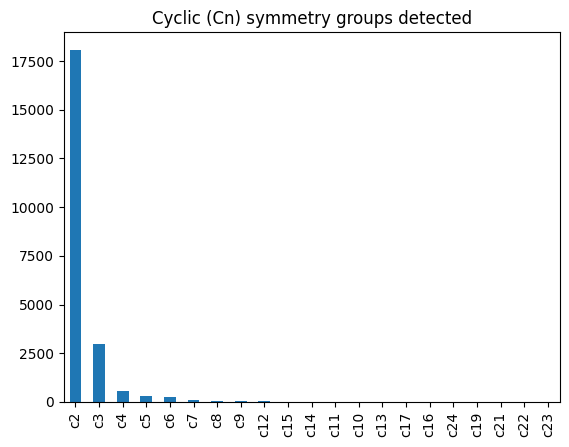

In [90]:
cx = cyclic_assemblies_variants.plot(kind="bar")
cx.set_title("Cyclic (Cn) symmetry groups detected")

In [91]:
dihedral_assemblies_variants = dihedral_assemblies['PRIMARY_SYM'].value_counts()
dihedral_assemblies_variants

d2     2927
d3      982
d4      358
d5      154
d7       91
d6       87
d8       16
d10       3
d9        3
d16       2
d17       2
d11       2
d24       1
d12       1
Name: PRIMARY_SYM, dtype: int64

Text(0.5, 1.0, 'Dihedral (Dn) symmetry groups detected')

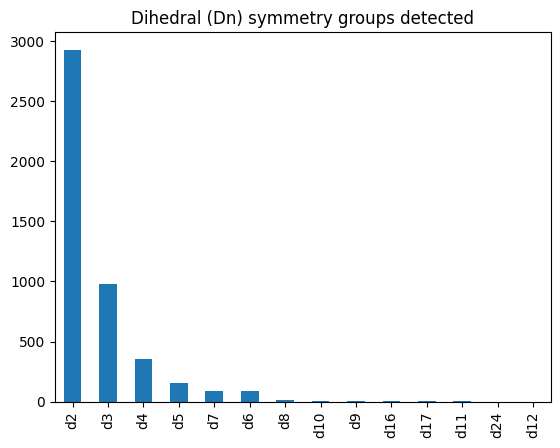

In [92]:
dx = dihedral_assemblies_variants.plot(kind="bar")
dx.set_title("Dihedral (Dn) symmetry groups detected")

## 5.3) Listing assemblies with inconsistent symmetries

We can list assemblies where the symmetry data is inconsistent between different instances of the same assembly. This can highlight potential annotation errors, or genuinely interesting assemblies.

In [93]:
df_protein[df_protein['CONSISTENT_SYMMETRY'] == False]

,HASH_ASSEMBLY_STRING,ASSEMBLY_STRING,PDB_COMPLEX_ID,COMPLEX_PORTAL_ID,ASSEMBLY_NAME,NAME_SOURCE,ASSEMBLIES,PREFERED_ASSEMBLIES,EXP_METHOD,SPECIES_NAME,...,hasRNAComponent,hasDNAComponent,ASSEMBLY_POLYMERS,hasAllUNPMapping,hasAnyUNPMapping,ASSEMBLY_TYPE,SYMMETRY_OPS,CONSISTENT_SYMMETRY,ALL_SYM,PRIMARY_SYM
191,3afcec492339114cea8cbcce78383e2d,A0A037USE5_2,PDB-CPX-100192,NaN,DNA-binding protein HU,protein name from UniProt,"4n1v_1,5l8z_1,5ogu_1","5l8z_1,4n1v_1,5ogu_1","Other,X-ray diffraction",Spiroplasma melliferum,...,False,False,protein,True,True,homomeric,"c2,c2,no-sym",False,"no-sym, c2",c2
307,fd337aa8038a465b0e6601a643aac684,A0A059VAZ3_6,PDB-CPX-100308,NaN,Lon protease,protein name from UniProt,"4ypl_1,4ypm_1","4ypm_1,4ypl_1",X-ray diffraction,Meiothermus sp.,...,False,False,protein,True,True,homomeric,"c6,c3",False,"c3, c6",c6
489,6a638a89496e662fecb43870f125b6b6,"A0A074MDU6_1,A0A074MDU6_3",PDB-CPX-100490,NaN,Alpha/beta hydrolase fold-3 domain-containing ...,protein name from UniProt,"6kf1_1,7w8n_1","6kf1_1,7w8n_1",Other,Erythrobacter longus,...,False,False,protein,True,True,heteromeric,"c2,no-sym",False,"no-sym, c2",c2
798,4108c9e2b364bbda50550eb8e3d4f826,"A0A097BW12_60,A0A097BW12_60,A0A097BW12_60,A0A0...",PDB-CPX-100799,NaN,viral protein 1,protein name from UniProt,"6crp_1,6crr_1,6cs3_1,6csg_1,6mzi_1,7t9p_1,7taf...","6crp_1,7taj_1,6csg_1,7t9p_1,7taf_1,6mzi_1,6cs3...",Other,enterovirus D68,...,False,False,protein,True,True,heteromeric,"i,no-sym,i,no-sym,no-sym,i,i,i,no-sym,no-sym",False,"no-sym, i",i
883,ae0508d8802c172b77aa2fc8219fe539,A0A0A1EQY0_2,PDB-CPX-100884,NaN,Formate dehydrogenase,protein name from UniProt,"5dn9_1,5dna_1,5dna_2,6d4b_1,6d4c_1,8hty_1,8hty_2","5dna_1,6d4b_1,6d4c_1,5dn9_1,8hty_1","Other,X-ray diffraction",Candida boidinii,...,False,False,protein,True,True,homomeric,"c2,c2,c2,c2,no-sym",False,"no-sym, c2",c2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98806,9defe5e7d3a3b4e1d38d6fe93bf6e147,V7II86_2,PDB-CPX-198807,NaN,Threonine--tRNA ligase,protein name from UniProt,"6l2p_1,6l2q_1,7cbg_1,7cbh_1,7cbi_1,7wm7_1,7wmf...","6l2p_1,7wmf_1,7cbh_1,7cbi_1,7cbg_1,6l2q_1,7wm7...",Other,Salmonella enterica,...,False,False,protein,True,True,homomeric,"c2,no-sym,c2,c2,c2,c2,no-sym,no-sym",False,"no-sym, c2",c2
98818,7f9aac2256ae79e93489fda29e8cb712,V9P0A9_6,PDB-CPX-198819,NaN,Chalcone isomerase N-terminal domain-containin...,protein name from UniProt,"4c9s_1,4c9t_1,4d06_1,4d4f_1,8b7r_1,8b7u_1,8b7u...","8b7u_2,4d4f_1,8b7z_1,4c9s_1,8b7r_1,4c9t_1,4d06_1","Other,X-ray diffraction",DSM 3995,...,False,False,protein,True,True,homomeric,"no-sym,d3,no-sym,d3,no-sym,d3,d3",False,"no-sym, d3",d3
98827,54f47025b0265d9b7e6bbfdadd5110a8,"V9VEF3_60,V9VEF3_60,V9VEF3_60,V9VEF3_60",PDB-CPX-198828,NaN,Coxsackievirus capsid protein VP2,protein name from UniProt,"4q4v_1,4q4w_1,4q4x_1,4q4y_1,6tsd_1,7oj7_1","7oj7_1,4q4v_1,6tsd_1,4q4y_1,4q4x_1,4q4w_1","Other,X-ray diffraction",Human coxsackievirus,...,False,False,protein,True,True,heteromeric,"no-sym,i,i,i,i,i",False,"no-sym, i",i
98832,43b3c6be0455820ef304dbbb3242a152,W0DP94_2,PDB-CPX-198833,NaN,Thiocyanate dehydrogenase,protein name from UniProt,"5f75_1,5f75_2,5oex_2,5oex_3,6g50_1,6g50_3,6g5m...","6g5m_1,6g50_3,6uwe_1,5oex_2,5f75_1,8bpn_1,6i3q_1","Other,X-ray diffraction",Thioalkalivibrio paradoxus,...,False,False,protein,True,True,homomeric,"c2,c2,c2,c2,c2,no-sym,c2",False,"no-sym, c2",c2


In [94]:
# Assemblies with inconsistent symmetries and observed in more than 10 PDB structure
# df_symmetry = df_protein[(df_protein["CONSISTENT_SYMMETRY"] == False) & (df_protein["NUM_PDB"] > 10)]
df_symmetry = df_protein[(df_protein["CONSISTENT_SYMMETRY"] == False)]
df_symmetry

,HASH_ASSEMBLY_STRING,ASSEMBLY_STRING,PDB_COMPLEX_ID,COMPLEX_PORTAL_ID,ASSEMBLY_NAME,NAME_SOURCE,ASSEMBLIES,PREFERED_ASSEMBLIES,EXP_METHOD,SPECIES_NAME,...,hasRNAComponent,hasDNAComponent,ASSEMBLY_POLYMERS,hasAllUNPMapping,hasAnyUNPMapping,ASSEMBLY_TYPE,SYMMETRY_OPS,CONSISTENT_SYMMETRY,ALL_SYM,PRIMARY_SYM
191,3afcec492339114cea8cbcce78383e2d,A0A037USE5_2,PDB-CPX-100192,NaN,DNA-binding protein HU,protein name from UniProt,"4n1v_1,5l8z_1,5ogu_1","5l8z_1,4n1v_1,5ogu_1","Other,X-ray diffraction",Spiroplasma melliferum,...,False,False,protein,True,True,homomeric,"c2,c2,no-sym",False,"no-sym, c2",c2
307,fd337aa8038a465b0e6601a643aac684,A0A059VAZ3_6,PDB-CPX-100308,NaN,Lon protease,protein name from UniProt,"4ypl_1,4ypm_1","4ypm_1,4ypl_1",X-ray diffraction,Meiothermus sp.,...,False,False,protein,True,True,homomeric,"c6,c3",False,"c3, c6",c6
489,6a638a89496e662fecb43870f125b6b6,"A0A074MDU6_1,A0A074MDU6_3",PDB-CPX-100490,NaN,Alpha/beta hydrolase fold-3 domain-containing ...,protein name from UniProt,"6kf1_1,7w8n_1","6kf1_1,7w8n_1",Other,Erythrobacter longus,...,False,False,protein,True,True,heteromeric,"c2,no-sym",False,"no-sym, c2",c2
798,4108c9e2b364bbda50550eb8e3d4f826,"A0A097BW12_60,A0A097BW12_60,A0A097BW12_60,A0A0...",PDB-CPX-100799,NaN,viral protein 1,protein name from UniProt,"6crp_1,6crr_1,6cs3_1,6csg_1,6mzi_1,7t9p_1,7taf...","6crp_1,7taj_1,6csg_1,7t9p_1,7taf_1,6mzi_1,6cs3...",Other,enterovirus D68,...,False,False,protein,True,True,heteromeric,"i,no-sym,i,no-sym,no-sym,i,i,i,no-sym,no-sym",False,"no-sym, i",i
883,ae0508d8802c172b77aa2fc8219fe539,A0A0A1EQY0_2,PDB-CPX-100884,NaN,Formate dehydrogenase,protein name from UniProt,"5dn9_1,5dna_1,5dna_2,6d4b_1,6d4c_1,8hty_1,8hty_2","5dna_1,6d4b_1,6d4c_1,5dn9_1,8hty_1","Other,X-ray diffraction",Candida boidinii,...,False,False,protein,True,True,homomeric,"c2,c2,c2,c2,no-sym",False,"no-sym, c2",c2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98806,9defe5e7d3a3b4e1d38d6fe93bf6e147,V7II86_2,PDB-CPX-198807,NaN,Threonine--tRNA ligase,protein name from UniProt,"6l2p_1,6l2q_1,7cbg_1,7cbh_1,7cbi_1,7wm7_1,7wmf...","6l2p_1,7wmf_1,7cbh_1,7cbi_1,7cbg_1,6l2q_1,7wm7...",Other,Salmonella enterica,...,False,False,protein,True,True,homomeric,"c2,no-sym,c2,c2,c2,c2,no-sym,no-sym",False,"no-sym, c2",c2
98818,7f9aac2256ae79e93489fda29e8cb712,V9P0A9_6,PDB-CPX-198819,NaN,Chalcone isomerase N-terminal domain-containin...,protein name from UniProt,"4c9s_1,4c9t_1,4d06_1,4d4f_1,8b7r_1,8b7u_1,8b7u...","8b7u_2,4d4f_1,8b7z_1,4c9s_1,8b7r_1,4c9t_1,4d06_1","Other,X-ray diffraction",DSM 3995,...,False,False,protein,True,True,homomeric,"no-sym,d3,no-sym,d3,no-sym,d3,d3",False,"no-sym, d3",d3
98827,54f47025b0265d9b7e6bbfdadd5110a8,"V9VEF3_60,V9VEF3_60,V9VEF3_60,V9VEF3_60",PDB-CPX-198828,NaN,Coxsackievirus capsid protein VP2,protein name from UniProt,"4q4v_1,4q4w_1,4q4x_1,4q4y_1,6tsd_1,7oj7_1","7oj7_1,4q4v_1,6tsd_1,4q4y_1,4q4x_1,4q4w_1","Other,X-ray diffraction",Human coxsackievirus,...,False,False,protein,True,True,heteromeric,"no-sym,i,i,i,i,i",False,"no-sym, i",i
98832,43b3c6be0455820ef304dbbb3242a152,W0DP94_2,PDB-CPX-198833,NaN,Thiocyanate dehydrogenase,protein name from UniProt,"5f75_1,5f75_2,5oex_2,5oex_3,6g50_1,6g50_3,6g5m...","6g5m_1,6g50_3,6uwe_1,5oex_2,5f75_1,8bpn_1,6i3q_1","Other,X-ray diffraction",Thioalkalivibrio paradoxus,...,False,False,protein,True,True,homomeric,"c2,c2,c2,c2,c2,no-sym,c2",False,"no-sym, c2",c2


In [95]:
df2 = df_symmetry.copy()
df2["ASYM_ASSEMBLIES"] = df2.apply(lambda row: ui.get_asymmetrical_assemblies(row["PREFERED_ASSEMBLIES"], row["SYMMETRY_OPS"]), axis=1)
df2["EXTENDED_SYMMETRY_OPS"] = df2.apply(lambda row: ui.get_extended_symmetry_operators(row["PREFERED_ASSEMBLIES"], row["SYMMETRY_OPS"]), axis=1)
# df2["PRIMARY_SYM"] = df2["SYMMETRY_OPS"].apply(lambda x: ui.most_frequent_symmetry(x))

In [96]:
df3 = df2[["ASSEMBLY_STRING", "PDB_COMPLEX_ID", "ASSEMBLY_NAME", "PRIMARY_SYM", "ALL_SYM", "ASYM_ASSEMBLIES", "EXTENDED_SYMMETRY_OPS"]]
# df3.to_csv("asymmetrical_assemblies.csv", index=False)
df3

,ASSEMBLY_STRING,PDB_COMPLEX_ID,ASSEMBLY_NAME,PRIMARY_SYM,ALL_SYM,ASYM_ASSEMBLIES,EXTENDED_SYMMETRY_OPS
191,A0A037USE5_2,PDB-CPX-100192,DNA-binding protein HU,c2,"no-sym, c2",5ogu_1,"5l8z_1|c2, 4n1v_1|c2, 5ogu_1|no-sym"
307,A0A059VAZ3_6,PDB-CPX-100308,Lon protease,c6,"c3, c6",,"4ypm_1|c6, 4ypl_1|c3"
489,"A0A074MDU6_1,A0A074MDU6_3",PDB-CPX-100490,Alpha/beta hydrolase fold-3 domain-containing ...,c2,"no-sym, c2",7w8n_1,"6kf1_1|c2, 7w8n_1|no-sym"
798,"A0A097BW12_60,A0A097BW12_60,A0A097BW12_60,A0A0...",PDB-CPX-100799,viral protein 1,i,"no-sym, i","7taj_1, 7t9p_1, 7taf_1, 7tah_1, 7tag_1","6crp_1|i, 7taj_1|no-sym, 6csg_1|i, 7t9p_1|no-s..."
883,A0A0A1EQY0_2,PDB-CPX-100884,Formate dehydrogenase,c2,"no-sym, c2",8hty_1,"5dna_1|c2, 6d4b_1|c2, 6d4c_1|c2, 5dn9_1|c2, 8h..."
...,...,...,...,...,...,...,...
98806,V7II86_2,PDB-CPX-198807,Threonine--tRNA ligase,c2,"no-sym, c2","7wmf_1, 7wm7_1, 7wmi_1","6l2p_1|c2, 7wmf_1|no-sym, 7cbh_1|c2, 7cbi_1|c2..."
98818,V9P0A9_6,PDB-CPX-198819,Chalcone isomerase N-terminal domain-containin...,d3,"no-sym, d3","8b7u_2, 8b7z_1, 8b7r_1","8b7u_2|no-sym, 4d4f_1|d3, 8b7z_1|no-sym, 4c9s_..."
98827,"V9VEF3_60,V9VEF3_60,V9VEF3_60,V9VEF3_60",PDB-CPX-198828,Coxsackievirus capsid protein VP2,i,"no-sym, i",7oj7_1,"7oj7_1|no-sym, 4q4v_1|i, 6tsd_1|i, 4q4y_1|i, 4..."
98832,W0DP94_2,PDB-CPX-198833,Thiocyanate dehydrogenase,c2,"no-sym, c2",8bpn_1,"6g5m_1|c2, 6g50_3|c2, 6uwe_1|c2, 5oex_2|c2, 5f..."


In [97]:
df4 = df3[df3["ASYM_ASSEMBLIES"] != '']
df4.to_csv("asymmetrical_assemblies.csv", index=False)

In [98]:
# df4 = df3[df3["ASYM_ASSEMBLIES"] == '']
# df4["SYM_VARIANT"] = df4.apply(lambda row: ui.get_sym_variant(row["PRIMARY_SYM"], row["EXTENDED_SYMMETRY_OPS"]), axis=1)
# df4.to_csv("assemblies_multiple_symmetries.csv", index=False)

We can also investigate the data by explicitly excluding asymmetric C1 instance.

In [99]:
# Assemblies with inconsistent symmetry operators (excluding asymmetric C1) and observed in more than 10 PDB structure
df_protein[(df_protein["CONSISTENT_SYMMETRY"] == False) & (~df_protein["SYMMETRY_OPS"].str.contains("no-sym")) & (df_protein["NUM_PDB"] > 10)]

,HASH_ASSEMBLY_STRING,ASSEMBLY_STRING,PDB_COMPLEX_ID,COMPLEX_PORTAL_ID,ASSEMBLY_NAME,NAME_SOURCE,ASSEMBLIES,PREFERED_ASSEMBLIES,EXP_METHOD,SPECIES_NAME,...,hasRNAComponent,hasDNAComponent,ASSEMBLY_POLYMERS,hasAllUNPMapping,hasAnyUNPMapping,ASSEMBLY_TYPE,SYMMETRY_OPS,CONSISTENT_SYMMETRY,ALL_SYM,PRIMARY_SYM
6361,c9e43eb926ccc50f54f07e7df63bf288,A0L5S6_4,PDB-CPX-106362,NaN,Ion transport domain-containing protein,protein name from UniProt,"3zjz_1,3zjz_2,4cbc_1,4cbc_2,4f4l_1,4oxs_1,4oxs...","6sxe_1,6sxc_1,4pa6_1,6sxf_2,4pa9_1,6sx5_1,5bzb...","Other,X-ray diffraction",Magnetococcus marinus,...,False,False,protein,True,True,homomeric,"c4,c4,c4,c4,c4,c4,c2,c4,c4,c4,c4,c4,c4,c4,c4,c...",False,"c2, c4",c4
28834,f19ade366163ded0560e71644fa61bac,O32080_8,PDB-CPX-128835,NaN,Ktr system potassium uptake protein A,protein name from UniProt,"2hms_1,2hmt_1,2hmu_1,2hmv_1,2hmw_1,4j90_1,4j91...","2hmw_1,2hmv_1,2hms_1,6s5e_1,4j91_1,6s7r_1,6s5g...","Other,X-ray diffraction",Bacillus subtilis,...,False,False,protein,True,True,homomeric,"d4,d4,d2,d2,d4,d4,d2,d4,d4,d4,d2,d4,d4,d4,d4,d4",False,"d2, d4",d4
30502,b5e47583660cf4e2a8a4b5c1d3b83b00,O60701_6,PDB-CPX-130503,NaN,UDP-glucose 6-dehydrogenase,protein name from UniProt,"2q3e_1,2q3e_2,2qg4_1,2qg4_4,2qg4_5,2qg4_6,3itk...","6c5a_1,3prj_1,5tjh_1,6c5z_1,3khu_1,3itk_1,3tf5...","Other,X-ray diffraction",Humo sapiens,...,False,False,protein,True,True,homomeric,"d3,d3,d3,d3,d3,d3,d3,d3,d3,d3,d3,c2,d3,c2",False,"c2, d3",d3
31580,b47d7cfa24a4b0e3947b1661b676cba3,"O75899_1,Q9UBS5_1",PDB-CPX-131581,CPX-2955,GABA-B receptor complex,complex portal,"4mqe_1,4mqf_1,4mr7_1,4mr8_1,4mr9_1,4mrm_1,4ms1...","6uo9_1,6uoa_1,7cum_1,4mqf_1,4mrm_1,6vjm_1,6uo8...","Other,X-ray diffraction",Humo sapiens,...,False,False,protein,True,True,heteromeric,"c2,c2,c2,c2,c2,c2,c2,c2,c2,c3,c2,c2,c2,c2,c2,c...",False,"c2, c3",c2
32837,899f0b15d93332968377fa872bdf8406,P00338_4,PDB-CPX-132838,CPX-6573,L-lactate dehydrogenase A complex,complex portal,"1i10_1,1i10_2,4ajp_1,4jnk_1,4l4r_1,4l4s_1,4m49...","5zjf_1,4ajp_1,5ixs_1,6bb0_1,4qt0_1,4qsm_1,7m2n...","Other,X-ray diffraction",Humo sapiens,...,False,False,protein,True,True,homomeric,"d2,d2,d2,d2,d2,d2,d2,d2,d2,d2,d2,d2,d2,d2,d2,d...",False,"d2, c2",d2
34614,70d735e2dd14f4815fc66b68f8618f5b,"P01308_2,P01308_2",PDB-CPX-134615,NaN,Insulin A chain,protein name from UniProt,"1b9e_1,1b9e_2,1fub_1,1lph_6,1lph_7,1trz_6,1trz...","5urt_1,2c8r_1,2ws4_1,4ak0_1,6s4i_1,5boq_2,4cy7...","Other,X-ray diffraction",Humo sapiens,...,False,False,protein,True,True,heteromeric,"c2,c2,c2,c2,c2,c3,c2,c2,c2,c2,c2,c2,c2,c2,c2,c...",False,"c2, c3",c2
34650,c7399d7b36b511d5d26c34e6cf4fb6f3,"P01315_6,P01315_6",PDB-CPX-134651,NaN,Insulin A chain,protein name from UniProt,"1iza_3,1izb_3,1izb_4,1m5a_1,1mpj_3,1wav_7,1zni...","3fhp_1,3rto_1,3gky_1,1m5a_1","Other,X-ray diffraction",wild boar,...,False,False,protein,True,True,heteromeric,"d3,d3,c3,d3",False,"c3, d3",d3
36865,036cbc2d2ac8c1ee133fdc78d27a609c,P03069_3,PDB-CPX-136866,NaN,General control transcription factor GCN4,protein name from UniProt,"1gcm_1,1ij0_1,1ij1_1,1ij2_1,1ij3_1,1piq_1,1rb4...","2wq0_1,1rb4_1,5apu_1,2wq1_1,1gcm_1,1swi_1,5apy...",X-ray diffraction,Saccharomyces cerevisiae,...,False,False,protein,True,True,homomeric,"c3,c2,c3,c3,c3,c3,c3,c3,c3,c3,c3,c3,c3,c3,c3,c...",False,"c2, c3",c3
36874,da89f2afa781586e1dee74d1b25268a7,P03069_4,PDB-CPX-136875,NaN,General control transcription factor GCN4,protein name from UniProt,"1ce9_1,1gcl_1,1unt_1,1unu_1,1unv_1,1unw_1,1unx...","1unz_1,2ccn_1,1unu_1,2b22_1,1uo1_1,1unv_1,2ccf...","Other,X-ray diffraction",Saccharomyces cerevisiae,...,False,False,protein,True,True,homomeric,"c4,d2,c4,d2,c4,c4,d2,c4,c4,d2,c4,c4,c4,d2,c4,c...",False,"d2, c4",c4
43053,59b93f8c750ec059cf64335135b46383,P0ABP8_6,PDB-CPX-143054,NaN,Purine nucleoside phosphorylase DeoD-type,protein name from UniProt,"1a69_1,1ecp_1,1k9s_1,1otx_1,1oty_1,1ou4_1,1oum...","1ecp_1,3ooh_2,3ut6_1,3ooe_1,4ts9_1,4tti_1,1ou4...","Other,X-ray diffraction",Escherichia col

## Conclusion

This work provides an archive-wide analysis of assemblies in the PDB archive and demonstrates the power of mapping individual components of assemblies to external databases. Our new approach allows the otherwise complex aggregation of assemblies. With the help of mappings to external databases, it also became possible to name over 80% of assemblies in the PDB, representing over 90% of PDB entries. These names allow users of PDBe to find complexes that previously could only be found by relying on the title of the PDB entry or listing all the complex components. Searching by title or listing components is likely to lead to incomplete and inconsistent search results due to the heterogeneity of assemblies in the PDB archive. We are making the complexes name list and mapping data files available to the community to aid in analysing and identifying macromolecular complexes.

## Authors

* Sri Appasamy
* Mihaly Varadi

### Last updated January 2023